  # Metrics for hierarchical classification (model 2)
  
  
  This model uses four layers. In the first layer, every source is classified hierarchically as Stochastic, Transient or Periodic. Then, every source pass trough the next layers (Stochastic, Transient and Periodic). The final classification is dertermined by multiplying the probabilities of the first layer, with their correspondant probabilites of the Stochastic, Transient and Periodic layers. For instance, the probability of being RRL corresponds to the product of the probability of being periodic (according to the first layer) and the probability of being RRL (according to the periodic layer): 
 
 $$Prob_{final}(RRL) = Prob_{first \: layer}(Periodic)* Prob_{periodic \: layer}(RRL)$$
 
 And the probability of being a Blazar is computed as:
 
  $$Prob_{final}(Blazar) = Prob_{first \: layer}(Stochastic)* Prob_{stochastic \: layer}(Blazar)$$


 
 The final classification is definded by the maximum $Prob_{final}$
 


In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, model_selection, metrics, ensemble
import pickle
import itertools
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.ensemble import BalancedRandomForestClassifier as RandomForestClassifier
from scipy.stats import randint as sp_randint
from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedShuffleSplit

  ### Definition of names for plots and files

In [2]:
morethan5 = False

extragalactic = False
galactic = False

date = '2020609'

#names of files with detections, features and labels for the training set (v3)
labels_file = '../../alerce_trainingset/training_set_v7/dfcrossmatches_prioritized_v7.0.2.csv'


features_path = '/Users/psanchez/Documents/Postdoc/Alerce/new_DB/features/'

features_file = features_path+'features_for_ML_with_WISE.parquet'



### reading the training set files 

In [3]:
df_feat = pd.read_parquet(features_file)
#df_feat.set_index('oid',inplace=True)
#df_feat = pd.read_csv(features_file,index_col='oid')

df_labels = pd.read_csv(labels_file,index_col='oid')

#discarging infinite values
df_feat = df_feat.replace([np.inf, -np.inf], np.nan)

df_feat_for_stats = df_feat.copy()
print(df_labels['class_source'].values.size)
print(df_feat.head())

162491
              MHAOV_Period_1  MHAOV_Period_2  Amplitude_1  Amplitude_2  \
oid                                                                      
ZTF17aaaaavn        0.106021        0.613572     0.078912     0.097860   
ZTF17aaaadjh        0.233443        0.233454     0.493980     0.463765   
ZTF17aaaadwo        0.060049        0.216873     0.090708     0.196542   
ZTF17aaaajjv      526.315748      555.555529     0.539600     0.566276   
ZTF17aaaakjt        0.148265        0.148265     0.564867     0.572449   

              AndersonDarling_1  AndersonDarling_2  Autocor_length_1  \
oid                                                                    
ZTF17aaaaavn           0.847902           0.673712               2.0   
ZTF17aaaadjh           1.000000           1.000000               1.0   
ZTF17aaaadwo           0.903625           0.993806               1.0   
ZTF17aaaajjv           1.000000           1.000000              14.0   
ZTF17aaaakjt           0.999907           

In [4]:
#creating new labels to combine SNII and SNIIb classes, and to add RS-CVn as a new class
df_labels['class_original'] = df_labels['classALeRCE']
df_labels.loc[(df_labels['classALeRCE'] == 'RSCVn'), 'class_original'] = 'Periodic-Other'
df_labels.loc[(df_labels['class_original'] == 'SNIIn'), 'class_original'] = 'SNII'
df_labels.loc[(df_labels['class_original'] == 'EA'), 'class_original'] = 'E' #new name for paper
df_labels.loc[(df_labels['class_original'] == 'EB/EW'), 'class_original'] = 'E'#new name for paper
df_labels.loc[(df_labels['class_original'] == 'Ceph'), 'class_original'] = 'CEP'#new name for paper

#df_labels = df_labels[df_labels['source']!="ASASSN"]

df_labels = df_labels[(df_labels['class_source']!="ELL")]

bad_oid = ['ZTF18abslpjy','ZTF18acurqaw','ZTF18aboebre','ZTF18acvvsnu','ZTF19aaydpzi','ZTF19aatevrp','ZTF18abtteyy',
          'ZTF19aatmtne','ZTF18abtfgqr','ZTF18acetlrs','ZTF18abtmgfn','ZTF18acvvppd','ZTF18aczebty','ZTF18acefhxx',
          'ZTF18acvhggp','ZTF18adbktyj','ZTF18aarcypa','ZTF18accngee','ZTF18acwvcbz','ZTF19aacypbw','ZTF18acenqto',
          'ZTF19aapfnym','ZTF18acpefgk','ZTF18aavjcpf','ZTF18aceexmi','ZTF18accnmri','ZTF18acdvvgx',
          'ZTF18accnbgw','ZTF18acemhyb','ZTF19abqrrto','ZTF19aadolpe','ZTF18abxbmqh','ZTF20aacbwbm']



df_labels.drop(bad_oid,inplace=True)

#defining the classes included in the RF model

label_order = ['SNIa', 'SNIbc', 'SNII', 'SLSN','QSO','AGN', 'Blazar', 'YSO','CV/Nova','LPV',
               'E', 'DSCT', 'RRL', 'CEP','Periodic-Other']


labels = df_labels.loc[df_labels.class_original.isin(label_order)][["class_original"]]

#defining hierarchical classes:

labels['class_hierachical'] = labels['class_original']

labels.loc[(labels['class_hierachical'] == 'LPV') | (labels['class_hierachical'] == 'Periodic-Other') | (labels['class_hierachical'] == 'E')  | (labels['class_hierachical'] == 'DSCT') | (labels['class_hierachical'] == 'RRL') | (labels['class_hierachical'] == 'CEP') , 'class_hierachical'] = 'Periodic'

labels.loc[(labels['class_hierachical'] == 'SNIa') | (labels['class_hierachical'] == 'SNIbc') | (labels['class_hierachical'] == 'SNII') | (labels['class_hierachical'] == 'SLSN'), 'class_hierachical'] = 'Transient'

labels.loc[(labels['class_hierachical'] == 'YSO') | (labels['class_hierachical'] == 'CV/Nova')  |   (labels['class_hierachical'] == 'AGN') |  (labels['class_hierachical'] == 'QSO') | (labels['class_hierachical'] == 'Blazar')  , 'class_hierachical'] = 'Stochastic'

cm_classes_hierachical = ['Transient','Stochastic','Periodic']

cm_classes_original = label_order

print(labels['class_hierachical'].values.shape)
labels.head()

(161653,)


,class_original,class_hierachical
oid,,
ZTF19abdbtlb,Blazar,Stochastic
ZTF19abdktzn,Blazar,Stochastic
ZTF18acxhtzv,Blazar,Stochastic
ZTF19abjpqvm,Blazar,Stochastic
ZTF18acafkde,Blazar,Stochastic


In [5]:
#defining columns excluded from the df_nd table

rm_nd_cols = [
'n_det_1',
'n_det_2',
'n_pos_1',
'n_pos_2',
'n_neg_1',
'n_neg_2',
'first_mag_1',
'first_mag_2',
'MHPS_non_zero_1',
'MHPS_non_zero_2',
'MHPS_PN_flag_1',
'MHPS_PN_flag_2',
'mean_mag_1',
'mean_mag_2',
'min_mag_1',
'min_mag_2',
'W1','W2','W3','W4',  
#'w1mpro', 'w2mpro', 'w3mpro', 'w4mpro',
#'w1mag', 'w2mag' ,'w3mag','w4mag',
'iqr_1',
'iqr_2', 
'delta_mjd_fid_1',
'delta_mjd_fid_2',
'last_mjd_before_fid_1',
'last_mjd_before_fid_2',
#'g-r_max_corr',
#'g-r_mean_corr',
#'g-r_mean',
'g-r_ml',
'MHAOV_Period_1', 'MHAOV_Period_2',
]

df = labels.join(df_feat.drop(rm_nd_cols, axis=1),how='inner')
print(df['g-r_max'].values.size)

df = df.replace([np.inf, -np.inf], np.nan)
print(df['g-r_max'].values.size)
df_train = df.copy()
df_train = df_train.fillna(-999)
labels = df[['class_original','class_hierachical']]
df.drop(['Mean_1','Mean_2','class_original','class_hierachical'], axis=1, inplace=True)
df = df.fillna(-999)

print(len(labels['class_original'].values))

print(df['g-r_max'].values.size)
df.head()

116438
116438
116438
116438


,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,Beyond1Std_2,Con_1,Con_2,...,rb,sgscore1,W1-W2,W2-W3,r-W3,r-W2,g-W3,g-W2,delta_period_1,delta_period_2
oid,,,,,,,,,,,,,,,,,,,,,
ZTF18acxhtzv,0.297294,0.070918,0.999669,0.878954,1.0,1.0,0.166667,0.428571,0.0,0.0,...,0.870000,1.000000,0.850,2.426,8.151376,5.725376,8.223164,5.797164,0.086881,1.461400
ZTF18abtphro,0.274613,-999.000000,0.986429,-999.000000,2.0,-999.0,0.375000,-999.000000,0.0,-999.0,...,0.831667,0.986687,1.228,3.321,-999.000000,-999.000000,7.658440,4.337440,0.009855,-999.000000
ZTF18acejbcb,0.110290,0.060682,0.609409,0.712830,1.0,1.0,0.375000,0.200000,0.0,0.0,...,0.923572,0.024417,0.340,1.970,6.387238,4.417238,7.277533,5.307533,0.030629,0.000001
ZTF18acskqvq,0.088963,-999.000000,0.536479,-999.000000,1.0,-999.0,0.333333,-999.000000,0.0,-999.0,...,0.848571,0.992000,1.311,2.877,-999.000000,-999.000000,8.072067,5.195067,0.043885,-999.000000
ZTF18acujppo,0.128972,-999.000000,0.470641,-999.000000,2.0,-999.0,0.250000,-999.000000,0.0,-999.0,...,0.782857,0.972083,1.174,3.587,-999.000000,-999.000000,9.900870,6.313870,0.058970,-999.000000


In [6]:
print(df.columns)

Index(['Amplitude_1', 'Amplitude_2', 'AndersonDarling_1', 'AndersonDarling_2',
       'Autocor_length_1', 'Autocor_length_2', 'Beyond1Std_1', 'Beyond1Std_2',
       'Con_1', 'Con_2',
       ...
       'rb', 'sgscore1', 'W1-W2', 'W2-W3', 'r-W3', 'r-W2', 'g-W3', 'g-W2',
       'delta_period_1', 'delta_period_2'],
      dtype='object', length=152)


In [7]:
for idx, cl in enumerate(label_order):
   #print(idx, cl)
   print(cl, labels['class_original'][labels['class_original']==cl].shape[0])

SNIa 1272
SNIbc 94
SNII 328
SLSN 24
QSO 22279
AGN 1498
Blazar 1267
YSO 1740
CV/Nova 871
LPV 14076
E 37901
DSCT 732
RRL 32482
CEP 618
Periodic-Other 1256


  ### Defining functions to plot the confusion matrix and the feature importance

In [8]:
def plot_confusion_matrix(cm,cm_low,cm_high, classes, plot_name,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues,font=20,fig_x = 20, fig_y = 12):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm_aux = np.round((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100)
        cm_low = np.round((cm_low.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100)
        cm_high = np.round((cm_high.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100)
        cm = cm_aux
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    if morethan5: title='Confusion matrix for more than 5 samples per band'
    if extragalactic: title='Confusion matrix for |gal_b|>20'
    if galactic: title='Confusion matrix for |gal_b|<=20'


    fig, ax = plt.subplots(figsize=(fig_x, fig_y))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize = font+1)
    plt.yticks(tick_marks, classes, fontsize = font+1)

    #fmt = '.2f' if normalize else 'd'
    fmt =  'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        #plt.text(j, i, format(cm[i, j], fmt),
        if cm_high[i, j]>100: cm_high[i, j]=100
        plt.text(j, i,r"$%d^{+%d}_{-%d}$"%  (cm[i, j],cm_high[i, j]-cm[i, j],cm[i, j]-cm_low[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize = font)

    plt.tight_layout()
    plt.ylabel('True label', fontsize = font+2)
    plt.xlabel('Predicted label',fontsize = font+2)
    plt.savefig(plot_name, bbox_inches='tight')
    #plt.close()
    
    
def plot_feature_importances(model, feature_names,feature_importances_name):
    I = np.argsort(model.feature_importances_)[::-1]
    I = I[0:60]
    fig, ax = plt.subplots(figsize=(16, 5), tight_layout=True)
    x_plot = np.arange(len(I))
    plt.xticks(x_plot, [feature_names[i] for i in I], rotation='vertical')
    ax.bar(x_plot, height=model.feature_importances_[I]);
    plt.savefig(feature_importances_name)
    #plt.close()

### Pre-processing training data

In [9]:
def compute_accuracy_periodic_transient_1band(min_bin,max_bin,dbin,feature,X_test_hierarchical_gr,original_class,predicted_class):
    bins_mag = np.arange(min_bin,max_bin,dbin)
    
    
    if 'n_det' in feature: 
        
        bins_mag = np.logspace(np.log10(min_bin),np.log10(max_bin),dbin, base=10.0,endpoint=True)
        
            
    df_test_1band = X_test_hierarchical_gr.copy()
    df_test_1band['class_original'] = original_class
    df_test_1band['predicted_class'] = predicted_class

    acc_mag_1band_AQB=[]    
    acc_mag_1band_AGN=[]
    acc_mag_1band_QSO=[]
    acc_mag_1band_Blazar=[]
    acc_mag_1band_LPV=[]
    acc_mag_1band_CV=[]
    
    nsamp_mag_1band_AQB=[]
    nsamp_mag_1band_AGN=[]
    nsamp_mag_1band_QSO=[]
    nsamp_mag_1band_Blazar=[]
    nsamp_mag_1band_LPV=[]
    nsamp_mag_1band_CV=[]
    
    
    for i in range(len(bins_mag)-1):
        
        if 'n_det' in feature:
            
            df_test_1band_aux = df_test_1band[((df_test_1band[feature]>=(bins_mag[i])) & (df_test_1band[feature]<(bins_mag[i+1])))]
            
        else:    
            df_test_1band_aux = df_test_1band[((df_test_1band[feature]>=(bins_mag[i]-dbin*0.5)) & (df_test_1band[feature]<(bins_mag[i]+dbin*0.5)))]
        
        
        df_test_1band_aux_AQB = df_test_1band_aux[df_test_1band_aux['class_original'].str.contains("SN")]     
        true_y_AQB = np.array(df_test_1band_aux_AQB['class_original'].values)
        if len(true_y_AQB)>0:
            true_y_AQB[np.where((true_y_AQB=="SNIa") |(true_y_AQB=="SNIbc") | (true_y_AQB=="SNII")  | (true_y_AQB=="SLSN"))]="SN"
            pred_y_AQB = np.array(df_test_1band_aux_AQB['predicted_class'].values)
            pred_y_AQB[np.where((pred_y_AQB=="SNIa") |(pred_y_AQB=="SNIbc") | (pred_y_AQB=="SNII")  | (pred_y_AQB=="SLSN"))]="SN"
            
            true_y_AQB[np.where((true_y_AQB!="SN"))]="Other"
            pred_y_AQB[np.where((pred_y_AQB!="SN"))]="Other"

            acc_AQB = metrics.recall_score(true_y_AQB, pred_y_AQB,pos_label="SN")
            nsamples_AQB = len(pred_y_AQB)
        else: 
            nsamples_AQB = 0
            acc_AQB = np.nan
            
        nsamp_mag_1band_AQB.append(nsamples_AQB)
        acc_mag_1band_AQB.append(acc_AQB)
            
        #AGN:
        df_test_1band_aux_AGN = df_test_1band_aux[df_test_1band_aux['class_original']=='E']
        true_y_AGN = df_test_1band_aux_AGN['class_original'].values
        true_y_AGN[np.where((true_y_AGN!="E"))]="Other"
        pred_y_AGN = df_test_1band_aux_AGN['predicted_class'].values
        pred_y_AGN[np.where((pred_y_AGN!="E"))]="Other"
        acc_AGN = metrics.recall_score(true_y_AGN, pred_y_AGN,pos_label="E")
        nsamples_AGN = len(pred_y_AGN)
        acc_mag_1band_AGN.append(acc_AGN)
        nsamp_mag_1band_AGN.append(nsamples_AGN)
        

        #QSO:
        df_test_1band_aux_QSO = df_test_1band_aux[df_test_1band_aux['class_original']=='DSCT']
        true_y_QSO = df_test_1band_aux_QSO['class_original'].values
        pred_y_QSO = df_test_1band_aux_QSO['predicted_class'].values
        true_y_QSO[np.where((true_y_QSO!="DSCT"))]="Other"
        pred_y_QSO[np.where((pred_y_QSO!="DSCT"))]="Other"
        acc_QSO = metrics.recall_score(true_y_QSO, pred_y_QSO,pos_label="DSCT")
        nsamples_QSO = len(pred_y_QSO)
        acc_mag_1band_QSO.append(acc_QSO)
        nsamp_mag_1band_QSO.append(nsamples_QSO)
        

        #Blazar:
        df_test_1band_aux_Blazar = df_test_1band_aux[df_test_1band_aux['class_original']=='RRL']
        true_y_Blazar = df_test_1band_aux_Blazar['class_original'].values
        pred_y_Blazar = df_test_1band_aux_Blazar['predicted_class'].values
        true_y_Blazar[np.where((true_y_Blazar!="RRL"))]="Other"
        pred_y_Blazar[np.where((pred_y_Blazar!="RRL"))]="Other"
        acc_Blazar = metrics.recall_score(true_y_Blazar, pred_y_Blazar,pos_label="RRL")
        nsamples_Blazar = len(pred_y_Blazar)
        acc_mag_1band_Blazar.append(acc_Blazar)
        nsamp_mag_1band_Blazar.append(nsamples_Blazar)
        
        #LPV:
        df_test_1band_aux_LPV = df_test_1band_aux[df_test_1band_aux['class_original']=='CEP']
        true_y_LPV = df_test_1band_aux_LPV['class_original'].values
        pred_y_LPV = df_test_1band_aux_LPV['predicted_class'].values
        true_y_LPV[np.where((true_y_LPV!="CEP"))]="Other"
        pred_y_LPV[np.where((pred_y_LPV!="CEP"))]="Other"
        acc_LPV = metrics.recall_score(true_y_LPV, pred_y_LPV,pos_label="CEP")
        nsamples_LPV = len(pred_y_LPV)
        acc_mag_1band_LPV.append(acc_LPV)
        nsamp_mag_1band_LPV.append(nsamples_LPV)
        
        
        #Cv/Nova:
        df_test_1band_aux_CV = df_test_1band_aux[df_test_1band_aux['class_original']=='Periodic-Other']
        true_y_CV = df_test_1band_aux_CV['class_original'].values
        pred_y_CV = df_test_1band_aux_CV['predicted_class'].values
        true_y_CV[np.where((true_y_CV!="Periodic-Other"))]="Other"
        pred_y_CV[np.where((pred_y_CV!="Periodic-Other"))]="Other"
        acc_CV = metrics.recall_score(true_y_CV, pred_y_CV,pos_label="Periodic-Other")
        nsamples_CV = len(pred_y_CV)
        acc_mag_1band_CV.append(acc_CV)
        nsamp_mag_1band_CV.append(nsamples_CV)
        
    acc_mag_1band_AQB = np.array(acc_mag_1band_AQB)        
    acc_mag_1band_AGN = np.array(acc_mag_1band_AGN)
    acc_mag_1band_QSO = np.array(acc_mag_1band_QSO)
    acc_mag_1band_Blazar = np.array(acc_mag_1band_Blazar)
    acc_mag_1band_LPV = np.array(acc_mag_1band_LPV)
    acc_mag_1band_CV = np.array(acc_mag_1band_CV)

    nsamp_mag_1band_AQB = np.array(nsamp_mag_1band_AQB)
    nsamp_mag_1band_AGN = np.array(nsamp_mag_1band_AGN)
    nsamp_mag_1band_QSO = np.array(nsamp_mag_1band_QSO)
    nsamp_mag_1band_Blazar = np.array(nsamp_mag_1band_Blazar)
    nsamp_mag_1band_LPV = np.array(nsamp_mag_1band_LPV)
    nsamp_mag_1band_CV = np.array(nsamp_mag_1band_CV)
    
    
    if 'n_det' in feature:
        bins_mag = bins_mag[:-1] + np.diff(bins_mag)*0.5
    else: 
        bins_mag = bins_mag[:-1]

    
    return(bins_mag,nsamp_mag_1band_AQB,acc_mag_1band_AQB,nsamp_mag_1band_AGN,acc_mag_1band_AGN,nsamp_mag_1band_QSO,acc_mag_1band_QSO,nsamp_mag_1band_Blazar,acc_mag_1band_Blazar,nsamp_mag_1band_CV,acc_mag_1band_CV,nsamp_mag_1band_LPV,acc_mag_1band_LPV)



In [10]:
def compute_accuracy_stochastic_1band(min_bin,max_bin,dbin,feature,X_test_hierarchical_gr,original_class,predicted_class):
    bins_mag = np.arange(min_bin,max_bin,dbin)
    
    
    if 'n_det' in feature: 
        
        bins_mag = np.logspace(np.log10(min_bin),np.log10(max_bin),dbin, base=10.0,endpoint=True)
        #bins_mag = np.power(10,bins_mag)
        
        
    
    df_test_1band = X_test_hierarchical_gr.copy()
    df_test_1band['class_original'] = original_class
    df_test_1band['predicted_class'] = predicted_class

    acc_mag_1band_AQB=[]    
    acc_mag_1band_AGN=[]
    acc_mag_1band_QSO=[]
    acc_mag_1band_Blazar=[]
    acc_mag_1band_LPV=[]
    acc_mag_1band_YSO=[]
    acc_mag_1band_CV=[]
    
    nsamp_mag_1band_AQB=[]
    nsamp_mag_1band_AGN=[]
    nsamp_mag_1band_QSO=[]
    nsamp_mag_1band_Blazar=[]
    nsamp_mag_1band_LPV=[]
    nsamp_mag_1band_YSO=[]
    nsamp_mag_1band_CV=[]
    
    
    for i in range(len(bins_mag)-1):
        
        #'''
        if 'n_det' in feature:
            
            df_test_1band_aux = df_test_1band[((df_test_1band[feature]>=(bins_mag[i])) & (df_test_1band[feature]<(bins_mag[i+1])))]
            
        else:    
            df_test_1band_aux = df_test_1band[((df_test_1band[feature]>=(bins_mag[i]-dbin*0.5)) & (df_test_1band[feature]<(bins_mag[i]+dbin*0.5)))]
        #'''        
        
        #df_test_1band_aux = df_test_1band[((df_test_1band[feature]>=(bins_mag[i]-dbin*0.5)) & (df_test_1band[feature]<(bins_mag[i]+dbin*0.5)))]

        #AGN+QSO+Blazar
        
        df_test_1band_aux_AQB = df_test_1band_aux[(df_test_1band_aux['class_original']=='AGN') | (df_test_1band_aux['class_original']=='QSO') | (df_test_1band_aux['class_original']=='Blazar')]
        true_y_AQB = df_test_1band_aux_AQB['class_original'].values
        true_y_AQB[np.where((true_y_AQB=="AGN") |(true_y_AQB=="QSO") | (true_y_AQB=="Blazar"))]="AQB"
        pred_y_AQB = df_test_1band_aux_AQB['predicted_class'].values
        pred_y_AQB[np.where((pred_y_AQB=="AGN") |(pred_y_AQB=="QSO") | (pred_y_AQB=="Blazar"))]="AQB"
        true_y_AQB[np.where((true_y_AQB!="AQB"))]="Other"
        pred_y_AQB[np.where((pred_y_AQB!="AQB"))]="Other"
        acc_AQB = metrics.recall_score(true_y_AQB, pred_y_AQB,pos_label="AQB")
        nsamples_AQB = len(pred_y_AQB)
        nsamp_mag_1band_AQB.append(nsamples_AQB)
        acc_mag_1band_AQB.append(acc_AQB)
            
        #AGN:
        df_test_1band_aux_AGN = df_test_1band_aux[df_test_1band_aux['class_original']=='AGN']
        true_y_AGN = df_test_1band_aux_AGN['class_original'].values
        pred_y_AGN = df_test_1band_aux_AGN['predicted_class'].values
        true_y_AGN[np.where((true_y_AGN!="AGN"))]="Other"
        pred_y_AGN[np.where((pred_y_AGN!="AGN"))]="Other"
        acc_AGN = metrics.recall_score(true_y_AGN, pred_y_AGN,pos_label="AGN")
        nsamples_AGN = len(pred_y_AGN)
        acc_mag_1band_AGN.append(acc_AGN)
        nsamp_mag_1band_AGN.append(nsamples_AGN)
        #print("True AGN",true_y_AGN)
        #print("pred AGN",pred_y_AGN)
        

        #QSO:
        df_test_1band_aux_QSO = df_test_1band_aux[df_test_1band_aux['class_original']=='QSO']
        true_y_QSO = df_test_1band_aux_QSO['class_original'].values
        pred_y_QSO = df_test_1band_aux_QSO['predicted_class'].values
        true_y_QSO[np.where((true_y_QSO!="QSO"))]="Other"
        pred_y_QSO[np.where((pred_y_QSO!="QSO"))]="Other"
        acc_QSO = metrics.recall_score(true_y_QSO, pred_y_QSO,pos_label="QSO")
        nsamples_QSO = len(pred_y_QSO)
        acc_mag_1band_QSO.append(acc_QSO)
        nsamp_mag_1band_QSO.append(nsamples_QSO)
        '''
        print("True QSO",bins_mag[i],bins_mag[i+1],len(true_y_QSO))
        print("pred QSO",bins_mag[i],bins_mag[i+1],len(pred_y_QSO[np.where(pred_y_QSO=='QSO')]))
        print("pred AGN",bins_mag[i],bins_mag[i+1],len(pred_y_QSO[np.where(pred_y_QSO=='AGN')]))
        print("pred qso+agn", len(pred_y_QSO[np.where(pred_y_QSO=='QSO')]) + len(pred_y_QSO[np.where(pred_y_QSO=='AGN')]) )
        '''



        #Blazar:
        df_test_1band_aux_Blazar = df_test_1band_aux[df_test_1band_aux['class_original']=='Blazar']
        true_y_Blazar = df_test_1band_aux_Blazar['class_original'].values
        pred_y_Blazar = df_test_1band_aux_Blazar['predicted_class'].values
        true_y_Blazar[np.where((true_y_Blazar!="Blazar"))]="Other"
        pred_y_Blazar[np.where((pred_y_Blazar!="Blazar"))]="Other"
        acc_Blazar = metrics.recall_score(true_y_Blazar, pred_y_Blazar,pos_label="Blazar")
        nsamples_Blazar = len(pred_y_Blazar)
        acc_mag_1band_Blazar.append(acc_Blazar)
        nsamp_mag_1band_Blazar.append(nsamples_Blazar)
        
        #LPV:
        df_test_1band_aux_LPV = df_test_1band_aux[df_test_1band_aux['class_original']=='LPV']
        true_y_LPV = df_test_1band_aux_LPV['class_original'].values
        pred_y_LPV = df_test_1band_aux_LPV['predicted_class'].values
        true_y_LPV[np.where((true_y_LPV!="LPV"))]="Other"
        pred_y_LPV[np.where((pred_y_LPV!="LPV"))]="Other"
        acc_LPV = metrics.recall_score(true_y_LPV, pred_y_LPV,pos_label="LPV")
        nsamples_LPV = len(pred_y_LPV)
        acc_mag_1band_LPV.append(acc_LPV)
        nsamp_mag_1band_LPV.append(nsamples_LPV)
        
        #YSO:
        df_test_1band_aux_YSO = df_test_1band_aux[df_test_1band_aux['class_original']=='YSO']
        true_y_YSO = df_test_1band_aux_YSO['class_original'].values
        pred_y_YSO = df_test_1band_aux_YSO['predicted_class'].values
        true_y_YSO[np.where((true_y_YSO!="YSO"))]="Other"
        pred_y_YSO[np.where((pred_y_YSO!="YSO"))]="Other"
        acc_YSO = metrics.recall_score(true_y_YSO, pred_y_YSO,pos_label="YSO")
        nsamples_YSO = len(pred_y_YSO)
        acc_mag_1band_YSO.append(acc_YSO)
        nsamp_mag_1band_YSO.append(nsamples_YSO)
        
        #Cv/Nova:
        df_test_1band_aux_CV = df_test_1band_aux[df_test_1band_aux['class_original']=='CV/Nova']
        true_y_CV = df_test_1band_aux_CV['class_original'].values
        pred_y_CV = df_test_1band_aux_CV['predicted_class'].values
        true_y_CV[np.where((true_y_CV!="CV/Nova"))]="Other"
        pred_y_CV[np.where((pred_y_CV!="CV/Nova"))]="Other"
        acc_CV = metrics.recall_score(true_y_CV, pred_y_CV,pos_label="CV/Nova")
        nsamples_CV = len(pred_y_CV)
        acc_mag_1band_CV.append(acc_CV)
        nsamp_mag_1band_CV.append(nsamples_CV)
        
    acc_mag_1band_AQB = np.array(acc_mag_1band_AQB)        
    acc_mag_1band_AGN = np.array(acc_mag_1band_AGN)
    acc_mag_1band_QSO = np.array(acc_mag_1band_QSO)
    acc_mag_1band_Blazar = np.array(acc_mag_1band_Blazar)
    acc_mag_1band_LPV = np.array(acc_mag_1band_LPV)
    acc_mag_1band_YSO = np.array(acc_mag_1band_YSO)
    acc_mag_1band_CV = np.array(acc_mag_1band_CV)

    nsamp_mag_1band_AQB = np.array(nsamp_mag_1band_AQB)
    nsamp_mag_1band_AGN = np.array(nsamp_mag_1band_AGN)
    nsamp_mag_1band_QSO = np.array(nsamp_mag_1band_QSO)
    nsamp_mag_1band_Blazar = np.array(nsamp_mag_1band_Blazar)
    nsamp_mag_1band_LPV = np.array(nsamp_mag_1band_LPV)
    nsamp_mag_1band_YSO = np.array(nsamp_mag_1band_YSO)
    nsamp_mag_1band_CV = np.array(nsamp_mag_1band_CV)
    
    #'''
    if 'n_det' in feature:
        bins_mag = bins_mag[:-1] + np.diff(bins_mag)*0.5
    else: 
        bins_mag = bins_mag[:-1]
    #'''
    
    return(bins_mag,nsamp_mag_1band_AQB,acc_mag_1band_AQB,nsamp_mag_1band_AGN,acc_mag_1band_AGN,nsamp_mag_1band_QSO,acc_mag_1band_QSO,nsamp_mag_1band_Blazar,acc_mag_1band_Blazar,nsamp_mag_1band_YSO,acc_mag_1band_YSO,nsamp_mag_1band_CV,acc_mag_1band_CV,nsamp_mag_1band_LPV,acc_mag_1band_LPV)



In [11]:
def compute_accuracy_stochastic_2band(min_bin,max_bin,dbin,feature,X_test_hierarchical_gr,original_class,predicted_class):
    bins_mag = np.arange(min_bin,max_bin,dbin)
    
    df_test_1band = X_test_hierarchical_gr.copy()
    df_test_1band['class_original'] = original_class
    df_test_1band['predicted_class'] = predicted_class
    
    acc_mag_1band_AGN=[]
    acc_mag_1band_QSO=[]
    acc_mag_1band_Blazar=[]
    acc_mag_1band_LPV=[]
    acc_mag_1band_YSO=[]
    acc_mag_1band_CV=[]
    
    nsamp_mag_1band_AGN=[]
    nsamp_mag_1band_QSO=[]
    nsamp_mag_1band_Blazar=[]
    nsamp_mag_1band_LPV=[]
    nsamp_mag_1band_YSO=[]
    nsamp_mag_1band_CV=[]
    
    #'''
    if 'n_det' in feature: 
        
        bins_mag = np.logspace(np.log10(min_bin),np.log10(max_bin),dbin, base=10.0,endpoint=True)
        #bins_mag = np.power(10,bins_mag)
        #print(bins_mag)
        
        #df_test_1band['tot_n_det'] = df_test_1band['n_det_1']+df_test_1band['n_det_2']
        #feature = 'tot_n_det'
    #'''
    
    acc_mag_1band_AQB=[]
    acc_mag_1band_AGN=[]
    acc_mag_1band_QSO=[]
    acc_mag_1band_Blazar=[]
    acc_mag_1band_LPV=[]
    acc_mag_1band_YSO=[]
    acc_mag_1band_CV=[]
    
    nsamp_mag_1band_AQB=[]
    nsamp_mag_1band_AGN=[]
    nsamp_mag_1band_QSO=[]
    nsamp_mag_1band_Blazar=[]
    nsamp_mag_1band_LPV=[]
    nsamp_mag_1band_YSO=[]
    nsamp_mag_1band_CV=[]
    
    
    for i in range(len(bins_mag)-1):
        #'''
        if 'n_det' in feature:
            
            df_test_1band_aux = df_test_1band[((df_test_1band[feature]>=(bins_mag[i])) & (df_test_1band[feature]<(bins_mag[i+1])))]
            
        else:    
            df_test_1band_aux = df_test_1band[((df_test_1band[feature]>=(bins_mag[i]-dbin*0.5)) & (df_test_1band[feature]<(bins_mag[i]+dbin*0.5)))]
        #'''
        #df_test_1band_aux = df_test_1band[((df_test_1band[feature]>=(bins_mag[i]-dbin*0.5)) & (df_test_1band[feature]<(bins_mag[i]+dbin*0.5)))]
        
        #AGN+QSO+Blazar
        
        df_test_1band_aux_AQB = df_test_1band_aux[(df_test_1band_aux['class_original']=='AGN') | (df_test_1band_aux['class_original']=='QSO') | (df_test_1band_aux['class_original']=='Blazar')]
        true_y_AQB = df_test_1band_aux_AQB['class_original'].values
        true_y_AQB[np.where((true_y_AQB=="AGN") |(true_y_AQB=="QSO") | (true_y_AQB=="Blazar"))]="AQB"
        pred_y_AQB = df_test_1band_aux_AQB['predicted_class'].values
        pred_y_AQB[np.where((pred_y_AQB=="AGN") |(pred_y_AQB=="QSO") | (pred_y_AQB=="Blazar"))]="AQB"
        true_y_AQB[np.where((true_y_AQB!="AQB"))]="Other"
        pred_y_AQB[np.where((pred_y_AQB!="AQB"))]="Other"
        acc_AQB = metrics.recall_score(true_y_AQB, pred_y_AQB,pos_label="AQB")
        nsamples_AQB = len(pred_y_AQB)
        nsamp_mag_1band_AQB.append(nsamples_AQB)
        acc_mag_1band_AQB.append(acc_AQB)
        
        
        #AGN:
        df_test_1band_aux_AGN = df_test_1band_aux[df_test_1band_aux['class_original']=='AGN']
        true_y_AGN = df_test_1band_aux_AGN['class_original'].values
        pred_y_AGN = df_test_1band_aux_AGN['predicted_class'].values
        true_y_AGN[np.where((true_y_AGN!="AGN"))]="Other"
        pred_y_AGN[np.where((pred_y_AGN!="AGN"))]="Other"
        acc_AGN = metrics.recall_score(true_y_AGN, pred_y_AGN,pos_label="AGN")
        nsamples_AGN = len(pred_y_AGN)
        nsamp_mag_1band_AGN.append(nsamples_AGN)
        acc_mag_1band_AGN.append(acc_AGN)
        #print("true AGN",true_y_AGN)
        #print("pred AGN",pred_y_AGN)

        #QSO:
        df_test_1band_aux_QSO = df_test_1band_aux[df_test_1band_aux['class_original']=='QSO']
        true_y_QSO = df_test_1band_aux_QSO['class_original'].values
        pred_y_QSO = df_test_1band_aux_QSO['predicted_class'].values
        true_y_QSO[np.where((true_y_QSO!="QSO"))]="Other"
        pred_y_QSO[np.where((pred_y_QSO!="QSO"))]="Other"
        acc_QSO = metrics.recall_score(true_y_QSO, pred_y_QSO,pos_label="QSO")
        nsamples_QSO = len(pred_y_QSO)
        acc_mag_1band_QSO.append(acc_QSO)
        nsamp_mag_1band_QSO.append(nsamples_QSO)
        '''
        print("True QSO",bins_mag[i],bins_mag[i+1],len(true_y_QSO))
        print("pred QSO",bins_mag[i],bins_mag[i+1],len(pred_y_QSO[np.where(pred_y_QSO=='QSO')]))
        print("pred AGN",bins_mag[i],bins_mag[i+1],len(pred_y_QSO[np.where(pred_y_QSO=='AGN')]))
        print("pred qso+agn", len(pred_y_QSO[np.where(pred_y_QSO=='QSO')]) + len(pred_y_QSO[np.where(pred_y_QSO=='AGN')]) )
        '''

        #Blazar:
        df_test_1band_aux_Blazar = df_test_1band_aux[df_test_1band_aux['class_original']=='Blazar']
        true_y_Blazar = df_test_1band_aux_Blazar['class_original'].values
        pred_y_Blazar = df_test_1band_aux_Blazar['predicted_class'].values
        true_y_Blazar[np.where((true_y_Blazar!="Blazar"))]="Other"
        pred_y_Blazar[np.where((pred_y_Blazar!="Blazar"))]="Other"
        acc_Blazar = metrics.recall_score(true_y_Blazar, pred_y_Blazar,pos_label="Blazar")
        nsamples_Blazar = len(pred_y_Blazar)
        acc_mag_1band_Blazar.append(acc_Blazar)
        nsamp_mag_1band_Blazar.append(nsamples_Blazar)
        
        #LPV:
        df_test_1band_aux_LPV = df_test_1band_aux[df_test_1band_aux['class_original']=='LPV']
        true_y_LPV = df_test_1band_aux_LPV['class_original'].values
        pred_y_LPV = df_test_1band_aux_LPV['predicted_class'].values
        true_y_LPV[np.where((true_y_LPV!="LPV"))]="Other"
        pred_y_LPV[np.where((pred_y_LPV!="LPV"))]="Other"
        acc_LPV = metrics.recall_score(true_y_LPV, pred_y_LPV,pos_label="LPV")
        nsamples_LPV = len(pred_y_LPV)
        acc_mag_1band_LPV.append(acc_LPV)
        nsamp_mag_1band_LPV.append(nsamples_LPV)
        
        #YSO:
        df_test_1band_aux_YSO = df_test_1band_aux[df_test_1band_aux['class_original']=='YSO']
        true_y_YSO = df_test_1band_aux_YSO['class_original'].values
        pred_y_YSO = df_test_1band_aux_YSO['predicted_class'].values
        true_y_YSO[np.where((true_y_YSO!="YSO"))]="Other"
        pred_y_YSO[np.where((pred_y_YSO!="YSO"))]="Other"
        acc_YSO = metrics.recall_score(true_y_YSO, pred_y_YSO,pos_label="YSO")
        nsamples_YSO = len(pred_y_YSO)
        acc_mag_1band_YSO.append(acc_YSO)
        nsamp_mag_1band_YSO.append(nsamples_YSO)
        
        #Cv/Nova:
        df_test_1band_aux_CV = df_test_1band_aux[df_test_1band_aux['class_original']=='CV/Nova']
        true_y_CV = df_test_1band_aux_CV['class_original'].values
        pred_y_CV = df_test_1band_aux_CV['predicted_class'].values
        true_y_CV[np.where((true_y_CV!="CV/Nova"))]="Other"
        pred_y_CV[np.where((pred_y_CV!="CV/Nova"))]="Other"
        acc_CV = metrics.recall_score(true_y_CV, pred_y_CV,pos_label="CV/Nova")
        nsamples_CV = len(pred_y_CV)
        acc_mag_1band_CV.append(acc_CV)
        nsamp_mag_1band_CV.append(nsamples_CV)
        
        
    acc_mag_1band_AQB = np.array(acc_mag_1band_AQB)
    acc_mag_1band_AGN = np.array(acc_mag_1band_AGN)
    acc_mag_1band_QSO = np.array(acc_mag_1band_QSO)
    acc_mag_1band_Blazar = np.array(acc_mag_1band_Blazar)
    acc_mag_1band_LPV = np.array(acc_mag_1band_LPV)
    acc_mag_1band_YSO = np.array(acc_mag_1band_YSO)
    acc_mag_1band_CV = np.array(acc_mag_1band_CV)

    nsamp_mag_1band_AQB = np.array(nsamp_mag_1band_AQB)
    nsamp_mag_1band_AGN = np.array(nsamp_mag_1band_AGN)
    nsamp_mag_1band_QSO = np.array(nsamp_mag_1band_QSO)
    nsamp_mag_1band_Blazar = np.array(nsamp_mag_1band_Blazar)
    nsamp_mag_1band_LPV = np.array(nsamp_mag_1band_LPV)
    nsamp_mag_1band_YSO = np.array(nsamp_mag_1band_YSO)
    nsamp_mag_1band_CV = np.array(nsamp_mag_1band_CV)
    
    #'''
    if 'n_det' in feature:
        bins_mag = bins_mag[:-1] + np.diff(bins_mag)*0.5
    else: 
        bins_mag = bins_mag[:-1]
    #'''
    
    return(bins_mag,nsamp_mag_1band_AQB,acc_mag_1band_AQB,nsamp_mag_1band_AGN,acc_mag_1band_AGN,nsamp_mag_1band_QSO,acc_mag_1band_QSO,nsamp_mag_1band_Blazar,acc_mag_1band_Blazar,nsamp_mag_1band_YSO,acc_mag_1band_YSO,nsamp_mag_1band_CV,acc_mag_1band_CV,nsamp_mag_1band_LPV,acc_mag_1band_LPV)



In [12]:
def compute_accuracy_periodic_transient_2band(min_bin,max_bin,dbin,feature,X_test_hierarchical_gr,original_class,predicted_class):
    bins_mag = np.arange(min_bin,max_bin,dbin)
    
    df_test_1band = X_test_hierarchical_gr.copy()
    df_test_1band['class_original'] = original_class
    df_test_1band['predicted_class'] = predicted_class
    
    acc_mag_1band_AGN=[]
    acc_mag_1band_QSO=[]
    acc_mag_1band_Blazar=[]
    acc_mag_1band_LPV=[]
    acc_mag_1band_YSO=[]
    acc_mag_1band_CV=[]
    
    nsamp_mag_1band_AGN=[]
    nsamp_mag_1band_QSO=[]
    nsamp_mag_1band_Blazar=[]
    nsamp_mag_1band_LPV=[]
    nsamp_mag_1band_YSO=[]
    nsamp_mag_1band_CV=[]
    
    #'''
    if 'n_det' in feature: 
        
        bins_mag = np.logspace(np.log10(min_bin),np.log10(max_bin),dbin, base=10.0,endpoint=True)
        #bins_mag = np.power(10,bins_mag)
        print(bins_mag)
        
        #df_test_1band['tot_n_det'] = df_test_1band['n_det_1']+df_test_1band['n_det_2']
        #feature = 'tot_n_det'
    #'''
    
    acc_mag_1band_AQB=[]
    acc_mag_1band_AGN=[]
    acc_mag_1band_QSO=[]
    acc_mag_1band_Blazar=[]
    acc_mag_1band_LPV=[]
    acc_mag_1band_YSO=[]
    acc_mag_1band_CV=[]
    
    nsamp_mag_1band_AQB=[]
    nsamp_mag_1band_AGN=[]
    nsamp_mag_1band_QSO=[]
    nsamp_mag_1band_Blazar=[]
    nsamp_mag_1band_LPV=[]
    nsamp_mag_1band_YSO=[]
    nsamp_mag_1band_CV=[]
    
    
    for i in range(len(bins_mag)-1):
        #'''
        if 'n_det' in feature:
            
            df_test_1band_aux = df_test_1band[((df_test_1band[feature]>=(bins_mag[i])) & (df_test_1band[feature]<(bins_mag[i+1])))]
            
        else:    
            df_test_1band_aux = df_test_1band[((df_test_1band[feature]>=(bins_mag[i]-dbin*0.5)) & (df_test_1band[feature]<(bins_mag[i]+dbin*0.5)))]
        #'''
        #df_test_1band_aux = df_test_1band[((df_test_1band[feature]>=(bins_mag[i]-dbin*0.5)) & (df_test_1band[feature]<(bins_mag[i]+dbin*0.5)))]
        
        #Transients (all together)
        

        #df_test_1band_aux_AQB = df_test_1band_aux.iloc[(np.flatnonzero(np.core.defchararray.find(df_test_1band_aux['class_original'].values,"SN")!=-1)),:]                                                                                           
        df_test_1band_aux_AQB = df_test_1band_aux[df_test_1band_aux['class_original'].str.contains("SN")]            
        true_y_AQB = np.array(df_test_1band_aux_AQB['class_original'].values)
        if len(true_y_AQB)>0:
            true_y_AQB[np.where((true_y_AQB=="SNIa") |(true_y_AQB=="SNIbc") | (true_y_AQB=="SNII") | (true_y_AQB=="SLSN"))]="SN"
            pred_y_AQB = np.array(df_test_1band_aux_AQB['predicted_class'].values)
            pred_y_AQB[np.where((pred_y_AQB=="SNIa") |(pred_y_AQB=="SNIbc") | (pred_y_AQB=="SNII") | (pred_y_AQB=="SLSN"))]="SN"
            true_y_AQB[np.where((true_y_AQB!="SN"))]="Other"
            pred_y_AQB[np.where((pred_y_AQB!="SN"))]="Other"
            acc_AQB = metrics.recall_score(true_y_AQB, pred_y_AQB,pos_label="SN")
            nsamples_AQB = len(pred_y_AQB)
        else: 
            nsamples_AQB = 0
            acc_AQB = np.nan
        nsamp_mag_1band_AQB.append(nsamples_AQB)
        acc_mag_1band_AQB.append(acc_AQB)
        
        
        #AGN:
        df_test_1band_aux_AGN = df_test_1band_aux[df_test_1band_aux['class_original']=='E']
        true_y_AGN = df_test_1band_aux_AGN['class_original'].values
        pred_y_AGN = df_test_1band_aux_AGN['predicted_class'].values
        true_y_AGN[np.where((true_y_AGN!="E"))]="Other"
        pred_y_AGN[np.where((pred_y_AGN!="E"))]="Other"
        acc_AGN = metrics.recall_score(true_y_AGN, pred_y_AGN,pos_label="E")
        nsamples_AGN = len(pred_y_AGN)
        nsamp_mag_1band_AGN.append(nsamples_AGN)
        acc_mag_1band_AGN.append(acc_AGN)
        #print("true AGN",true_y_AGN)
        #print("pred AGN",pred_y_AGN)

        #QSO:
        df_test_1band_aux_QSO = df_test_1band_aux[df_test_1band_aux['class_original']=='DSCT']
        true_y_QSO = df_test_1band_aux_QSO['class_original'].values
        pred_y_QSO = df_test_1band_aux_QSO['predicted_class'].values
        true_y_QSO[np.where((true_y_QSO!="DSCT"))]="Other"
        pred_y_QSO[np.where((pred_y_QSO!="DSCT"))]="Other"
        acc_QSO = metrics.recall_score(true_y_QSO, pred_y_QSO,pos_label="DSCT")
        nsamples_QSO = len(pred_y_QSO)
        acc_mag_1band_QSO.append(acc_QSO)
        nsamp_mag_1band_QSO.append(nsamples_QSO)
        '''
        print("True QSO",bins_mag[i],bins_mag[i+1],len(true_y_QSO))
        print("pred QSO",bins_mag[i],bins_mag[i+1],len(pred_y_QSO[np.where(pred_y_QSO=='QSO')]))
        print("pred AGN",bins_mag[i],bins_mag[i+1],len(pred_y_QSO[np.where(pred_y_QSO=='AGN')]))
        print("pred qso+agn", len(pred_y_QSO[np.where(pred_y_QSO=='QSO')]) + len(pred_y_QSO[np.where(pred_y_QSO=='AGN')]) )
        '''

        #Blazar:
        df_test_1band_aux_Blazar = df_test_1band_aux[df_test_1band_aux['class_original']=='RRL']
        true_y_Blazar = df_test_1band_aux_Blazar['class_original'].values
        pred_y_Blazar = df_test_1band_aux_Blazar['predicted_class'].values
        true_y_Blazar[np.where((true_y_Blazar!="RRL"))]="Other"
        pred_y_Blazar[np.where((pred_y_Blazar!="RRL"))]="Other"
        acc_Blazar = metrics.recall_score(true_y_Blazar, pred_y_Blazar,pos_label="RRL")
        nsamples_Blazar = len(pred_y_Blazar)
        acc_mag_1band_Blazar.append(acc_Blazar)
        nsamp_mag_1band_Blazar.append(nsamples_Blazar)
        
        #LPV:
        df_test_1band_aux_LPV = df_test_1band_aux[df_test_1band_aux['class_original']=='CEP']
        true_y_LPV = df_test_1band_aux_LPV['class_original'].values
        pred_y_LPV = df_test_1band_aux_LPV['predicted_class'].values
        true_y_LPV[np.where((true_y_LPV!="CEP"))]="Other"
        pred_y_LPV[np.where((pred_y_LPV!="CEP"))]="Other"
        acc_LPV = metrics.recall_score(true_y_LPV, pred_y_LPV,pos_label="CEP")
        nsamples_LPV = len(pred_y_LPV)
        acc_mag_1band_LPV.append(acc_LPV)
        nsamp_mag_1band_LPV.append(nsamples_LPV)
        
        #YSO:
        '''
        df_test_1band_aux_YSO = df_test_1band_aux[df_test_1band_aux['class_original']=='RSCVn']
        true_y_YSO = df_test_1band_aux_YSO['class_original'].values
        pred_y_YSO = df_test_1band_aux_YSO['predicted_class'].values
        true_y_YSO[np.where((true_y_YSO!="RSCVn"))]="Other"
        pred_y_YSO[np.where((pred_y_YSO!="RSCVn"))]="Other"
        print("bin ",bins_mag[i])
        print("true RSCVn", true_y_YSO)
        print("pred RSCVn", pred_y_YSO)
        acc_YSO = metrics.recall_score(true_y_YSO, pred_y_YSO,pos_label="RSCVn")
        print("acc", acc_YSO)
        nsamples_YSO = len(pred_y_YSO)
        acc_mag_1band_YSO.append(acc_YSO)
        nsamp_mag_1band_YSO.append(nsamples_YSO)
        '''
        
        #CV/Nova:
        df_test_1band_aux_CV = df_test_1band_aux[df_test_1band_aux['class_original']=='Periodic-Other']
        true_y_CV = df_test_1band_aux_CV['class_original'].values
        pred_y_CV = df_test_1band_aux_CV['predicted_class'].values
        #print(bins_mag[i])
        #print("true PO: ",true_y_CV)
        #print("pred PO: ",pred_y_CV)
        true_y_CV[np.where((true_y_CV!="Periodic-Other"))]="Other"
        pred_y_CV[np.where((pred_y_CV!="Periodic-Other"))]="Other"
        #print(bins_mag[i])
        #print("true PO: ",true_y_CV)
        #print("pred PO: ",pred_y_CV)
        acc_CV = metrics.recall_score(true_y_CV, pred_y_CV,pos_label="Periodic-Other")
        nsamples_CV = len(pred_y_CV)
        acc_mag_1band_CV.append(acc_CV)
        nsamp_mag_1band_CV.append(nsamples_CV)
        
        
    acc_mag_1band_AQB = np.array(acc_mag_1band_AQB)
    acc_mag_1band_AGN = np.array(acc_mag_1band_AGN)
    acc_mag_1band_QSO = np.array(acc_mag_1band_QSO)
    acc_mag_1band_Blazar = np.array(acc_mag_1band_Blazar)
    acc_mag_1band_LPV = np.array(acc_mag_1band_LPV)
    #acc_mag_1band_YSO = np.array(acc_mag_1band_YSO)
    acc_mag_1band_CV = np.array(acc_mag_1band_CV)

    nsamp_mag_1band_AQB = np.array(nsamp_mag_1band_AQB)
    nsamp_mag_1band_AGN = np.array(nsamp_mag_1band_AGN)
    nsamp_mag_1band_QSO = np.array(nsamp_mag_1band_QSO)
    nsamp_mag_1band_Blazar = np.array(nsamp_mag_1band_Blazar)
    nsamp_mag_1band_LPV = np.array(nsamp_mag_1band_LPV)
    #nsamp_mag_1band_YSO = np.array(nsamp_mag_1band_YSO)
    nsamp_mag_1band_CV = np.array(nsamp_mag_1band_CV)
    
    #print(acc_mag_1band_YSO)
    
    #'''
    if 'n_det' in feature:
        bins_mag = bins_mag[:-1] + np.diff(bins_mag)*0.5
    else: 
        bins_mag = bins_mag[:-1]
    #'''
    
    #return(bins_mag,nsamp_mag_1band_AQB,acc_mag_1band_AQB,nsamp_mag_1band_AGN,acc_mag_1band_AGN,nsamp_mag_1band_QSO,acc_mag_1band_QSO,nsamp_mag_1band_Blazar,acc_mag_1band_Blazar,nsamp_mag_1band_YSO,acc_mag_1band_YSO,nsamp_mag_1band_CV,acc_mag_1band_CV,nsamp_mag_1band_LPV,acc_mag_1band_LPV)
    return(bins_mag,nsamp_mag_1band_AQB,acc_mag_1band_AQB,nsamp_mag_1band_AGN,acc_mag_1band_AGN,nsamp_mag_1band_QSO,acc_mag_1band_QSO,nsamp_mag_1band_Blazar,acc_mag_1band_Blazar,nsamp_mag_1band_CV,acc_mag_1band_CV,nsamp_mag_1band_LPV,acc_mag_1band_LPV)





In [13]:
Y_hierarchical = labels['class_hierachical']#.values
Y_original = labels['class_original']#.values

print(len(labels['class_hierachical'].values))
print(len(labels['class_original'].values))
X_hierarchical = df.copy()#.columns.values.tolist()
#X_hierarchical = X_hierarchical.drop(['n_det_1','n_det_2'])

#splitting training set
#X_train_hierarchical, X_test_hierarchical, y_train_hierarchical, y_test_hierarchical, y_train_original, y_test_original  = model_selection.train_test_split(X_hierarchical,
#Y_hierarchical, Y_original, test_size=0.2, stratify=Y_original)

sss = StratifiedShuffleSplit(n_splits=20, test_size=0.2)
splitted_set = sss.split(X_hierarchical, Y_original)


rf_model_hierarchical = RandomForestClassifier(
                n_estimators=500,
                max_features='auto',
                max_depth=None,
                n_jobs=-1,
                bootstrap=True,
                class_weight='balanced_subsample',
                criterion='entropy',
                min_samples_split=2,
                min_samples_leaf=1)


rf_model_periodic = RandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=-1,
            class_weight='balanced_subsample',
            #bootstrap=False,
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_stochastic = RandomForestClassifier(
            n_estimators=500,
            max_features=0.2,#'auto',
            max_depth=None,
            n_jobs=-1,
            bootstrap=True,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)


rf_model_transient = RandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=-1,
            bootstrap=True,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)


ind = 0
list_Accuracy_first_layer = []
list_Balanced_Accuracy_first_layer = []
list_precision_first_layer = []
list_recall_first_layer = []
list_F1_Accuracy_first_layer = []

list_Accuracy_last_layer = []
list_Balanced_Accuracy_last_layer = []
list_precision_last_layer = []
list_recall_last_layer = []
list_F1_Accuracy_last_layer = []

list_cnf_matrix = []

list_cnf_matrix_hier = []

list_acc_mag_rband_AQB = []
list_acc_mag_rband_AGN = []
list_acc_mag_rband_QSO = []
list_acc_mag_rband_Blazar = []
list_acc_mag_rband_YSO = []
list_acc_mag_rband_CV = []
list_acc_mag_rband_LPV = []

list_acc_mag_gband_AQB = []
list_acc_mag_gband_AGN = []
list_acc_mag_gband_QSO = []
list_acc_mag_gband_Blazar = []
list_acc_mag_gband_YSO = []
list_acc_mag_gband_CV = []
list_acc_mag_gband_LPV = []

list_acc_nsamp_rband_AQB = []
list_acc_nsamp_rband_AGN = []
list_acc_nsamp_rband_QSO = []
list_acc_nsamp_rband_Blazar = []
list_acc_nsamp_rband_YSO = []
list_acc_nsamp_rband_CV = []
list_acc_nsamp_rband_LPV = []

list_acc_nsamp_gband_AQB = []
list_acc_nsamp_gband_AGN = []
list_acc_nsamp_gband_QSO = []
list_acc_nsamp_gband_Blazar = []
list_acc_nsamp_gband_YSO = []
list_acc_nsamp_gband_CV = []
list_acc_nsamp_gband_LPV = []

list_acc_mag_grband_AQB = []
list_acc_mag_grband_AGN = []
list_acc_mag_grband_QSO = []
list_acc_mag_grband_Blazar = []
list_acc_mag_grband_YSO = []
list_acc_mag_grband_CV = []
list_acc_mag_grband_LPV = []

list_acc_nsamp_grband_AQB = []
list_acc_nsamp_grband_AGN = []
list_acc_nsamp_grband_QSO = []
list_acc_nsamp_grband_Blazar = []
list_acc_nsamp_grband_YSO = []
list_acc_nsamp_grband_CV = []
list_acc_nsamp_grband_LPV = []

##

list_nsamp_mag_rband_AQB = []
list_nsamp_mag_rband_AGN = []
list_nsamp_mag_rband_QSO = []
list_nsamp_mag_rband_Blazar = []
list_nsamp_mag_rband_YSO = []
list_nsamp_mag_rband_CV = []
list_nsamp_mag_rband_LPV = []

list_nsamp_mag_gband_AQB = []
list_nsamp_mag_gband_AGN = []
list_nsamp_mag_gband_QSO = []
list_nsamp_mag_gband_Blazar = []
list_nsamp_mag_gband_YSO = []
list_nsamp_mag_gband_CV = []
list_nsamp_mag_gband_LPV = []

list_nsamp_nsamp_rband_AQB = []
list_nsamp_nsamp_rband_AGN = []
list_nsamp_nsamp_rband_QSO = []
list_nsamp_nsamp_rband_Blazar = []
list_nsamp_nsamp_rband_YSO = []
list_nsamp_nsamp_rband_CV = []
list_nsamp_nsamp_rband_LPV = []

list_nsamp_nsamp_gband_AQB = []
list_nsamp_nsamp_gband_AGN = []
list_nsamp_nsamp_gband_QSO = []
list_nsamp_nsamp_gband_Blazar = []
list_nsamp_nsamp_gband_YSO = []
list_nsamp_nsamp_gband_CV = []
list_nsamp_nsamp_gband_LPV = []

list_nsamp_mag_grband_AQB = []
list_nsamp_mag_grband_AGN = []
list_nsamp_mag_grband_QSO = []
list_nsamp_mag_grband_Blazar = []
list_nsamp_mag_grband_YSO = []
list_nsamp_mag_grband_CV = []
list_nsamp_mag_grband_LPV = []

list_nsamp_nsamp_grband_AQB = []
list_nsamp_nsamp_grband_AGN = []
list_nsamp_nsamp_grband_QSO = []
list_nsamp_nsamp_grband_Blazar = []
list_nsamp_nsamp_grband_YSO = []
list_nsamp_nsamp_grband_CV = []
list_nsamp_nsamp_grband_LPV = []

##

list_acc_mag_rband_transients = []
list_acc_mag_rband_EB = []
list_acc_mag_rband_DSCT = []
list_acc_mag_rband_RRL = []
list_acc_mag_rband_Ceph = []
#list_acc_mag_rband_RSCVn = []
list_acc_mag_rband_Other = []

list_acc_mag_gband_transients = []
list_acc_mag_gband_EB = []
list_acc_mag_gband_DSCT = []
list_acc_mag_gband_RRL = []
list_acc_mag_gband_Ceph = []
#list_acc_mag_gband_RSCVn = []
list_acc_mag_gband_Other = []

list_acc_nsamp_rband_transients = []
list_acc_nsamp_rband_EB = []
list_acc_nsamp_rband_DSCT = []
list_acc_nsamp_rband_RRL = []
list_acc_nsamp_rband_Ceph = []
#list_acc_nsamp_rband_RSCVn = []
list_acc_nsamp_rband_Other = []

list_acc_nsamp_gband_transients = []
list_acc_nsamp_gband_EB = []
list_acc_nsamp_gband_DSCT = []
list_acc_nsamp_gband_RRL = []
list_acc_nsamp_gband_Ceph = []
#list_acc_nsamp_gband_RSCVn = []
list_acc_nsamp_gband_Other = []

list_acc_mag_grband_transients = []
list_acc_mag_grband_EB = []
list_acc_mag_grband_DSCT = []
list_acc_mag_grband_RRL = []
list_acc_mag_grband_Ceph = []
#list_acc_mag_grband_RSCVn = []
list_acc_mag_grband_Other = []

list_acc_nsamp_grband_transients = []
list_acc_nsamp_grband_EB = []
list_acc_nsamp_grband_DSCT = []
list_acc_nsamp_grband_RRL = []
list_acc_nsamp_grband_Ceph = []
#list_acc_nsamp_grband_RSCVn = []
list_acc_nsamp_grband_Other = []

##

list_nsamp_mag_rband_transients = []
list_nsamp_mag_rband_EB = []
list_nsamp_mag_rband_DSCT = []
list_nsamp_mag_rband_RRL = []
list_nsamp_mag_rband_Ceph = []
#list_nsamp_mag_rband_RSCVn = []
list_nsamp_mag_rband_Other = []

list_nsamp_mag_gband_transients = []
list_nsamp_mag_gband_EB = []
list_nsamp_mag_gband_DSCT = []
list_nsamp_mag_gband_RRL = []
list_nsamp_mag_gband_Ceph = []
#list_nsamp_mag_gband_RSCVn = []
list_nsamp_mag_gband_Other = []

list_nsamp_nsamp_rband_transients = []
list_nsamp_nsamp_rband_EB = []
list_nsamp_nsamp_rband_DSCT = []
list_nsamp_nsamp_rband_RRL = []
list_nsamp_nsamp_rband_Ceph = []
#list_nsamp_nsamp_rband_RSCVn = []
list_nsamp_nsamp_rband_Other = []

list_nsamp_nsamp_gband_transients = []
list_nsamp_nsamp_gband_EB = []
list_nsamp_nsamp_gband_DSCT = []
list_nsamp_nsamp_gband_RRL = []
list_nsamp_nsamp_gband_Ceph = []
#list_nsamp_nsamp_gband_RSCVn = []
list_nsamp_nsamp_gband_Other = []

list_nsamp_mag_grband_transients = []
list_nsamp_mag_grband_EB = []
list_nsamp_mag_grband_DSCT = []
list_nsamp_mag_grband_RRL = []
list_nsamp_mag_grband_Ceph = []
#list_nsamp_mag_grband_RSCVn = []
list_nsamp_mag_grband_Other = []

list_nsamp_nsamp_grband_transients = []
list_nsamp_nsamp_grband_EB = []
list_nsamp_nsamp_grband_DSCT = []
list_nsamp_nsamp_grband_RRL = []
list_nsamp_nsamp_grband_Ceph = []
#list_nsamp_nsamp_grband_RSCVn = []
list_nsamp_nsamp_grband_Other = []

##



for train_index, test_index in splitted_set:
    print("iteration ", ind)
    X_train_hierarchical, X_test_hierarchical = X_hierarchical.iloc[train_index], X_hierarchical.iloc[test_index]
    y_train_original, y_test_original = Y_original.iloc[train_index], Y_original.iloc[test_index]
    y_train_hierarchical, y_test_hierarchical = Y_hierarchical.iloc[train_index], Y_hierarchical.iloc[test_index]
    
    X_test_hierarchical_for_stats = X_test_hierarchical.copy()
    X_test_hierarchical_for_stats = X_test_hierarchical_for_stats.join(df_feat_for_stats.loc[:,['n_det_1','n_det_2']],how='left')
    
    
    # separating training sets for sub-classes
    X_train_periodic = X_train_hierarchical.loc[y_train_hierarchical=='Periodic', :]
    #X_train_periodic.drop(['Mean_2'], axis=1,inplace=True)
    y_train_periodic = y_train_original.loc[y_train_hierarchical=='Periodic']

    X_train_stochastic = X_train_hierarchical.loc[y_train_hierarchical=='Stochastic', :]
    y_train_stochastic = y_train_original.loc[y_train_hierarchical=='Stochastic']

    X_train_transient = X_train_hierarchical.loc[y_train_hierarchical=='Transient', :]
    #X_train_transient.drop(['Mean_2'], axis=1,inplace=True)
    y_train_transient = y_train_original.loc[y_train_hierarchical=='Transient']

    #X_train_hierarchical.drop(['Mean_2'], axis=1,inplace=True)

    X_test_periodic = X_test_hierarchical#.drop(['Mean_2'], axis=1)
    X_test_stochastic = X_test_hierarchical#.drop(['Mean_2'], axis=1)
    X_test_transient = X_test_hierarchical#.drop(['Mean_2'], axis=1)
    #X_test_hierarchical = X_test_hierarchical#.drop(['Mean_2'], axis=1)
    
    print(len(y_train_periodic), len(y_train_stochastic), len(y_train_transient))
    
    #Training first layer of the RF model

    #print(X_train_hierarchical)
    #print(y_train_hierarchical)
    rf_model_hierarchical.fit(X_train_hierarchical, y_train_hierarchical)

    #testing first layer performance

    y_true, y_pred = y_test_hierarchical, rf_model_hierarchical.predict(X_test_hierarchical)
    y_pred_proba_hier = rf_model_hierarchical.predict_proba(X_test_hierarchical)

    classes_order_proba_hierarchical = rf_model_hierarchical.classes_

    acc_h = metrics.accuracy_score(y_true, y_pred)
    balandec_acc_h = metrics.balanced_accuracy_score(y_true, y_pred)
    pres_h = metrics.precision_score(y_true, y_pred, average='macro')
    rec_h = metrics.recall_score(y_true, y_pred, average='macro')
    f1_h = metrics.f1_score(y_true, y_pred, average='macro')
    
    list_Accuracy_first_layer.append(acc_h)
    list_Balanced_Accuracy_first_layer.append(balandec_acc_h)
    list_precision_first_layer.append(pres_h)
    list_recall_first_layer.append(rec_h)
    list_F1_Accuracy_first_layer.append(f1_h)
    
    print("macro F1:", acc_h)
    print("Balanced accuracy:", balandec_acc_h)
    
    cnf_matrix_hier = metrics.confusion_matrix(y_true, y_pred, labels=cm_classes_hierachical)
    print(cnf_matrix_hier)
    list_cnf_matrix_hier.append(cnf_matrix_hier)
    #Training Periodic layer
    rf_model_periodic.fit(X_train_periodic, y_train_periodic)

    # Applying periodic model to the test data
    y_true_periodic, y_pred_periodic = y_test_original, rf_model_periodic.predict(X_test_periodic)
    y_pred_proba_periodic = rf_model_periodic.predict_proba(X_test_periodic)
    
    classes_order_proba_periodic = rf_model_periodic.classes_
    
    #Training Stochastic layer
    rf_model_stochastic.fit(X_train_stochastic, y_train_stochastic)

    # Applying stochastic model to the test data
    y_true_stochastic, y_pred_stochastic  = y_test_original, rf_model_stochastic.predict(X_test_stochastic)
    y_pred_proba_stochastic = rf_model_stochastic.predict_proba(X_test_stochastic)
    
    classes_order_proba_stochastic = rf_model_stochastic.classes_
    
    #Training Transient layer
    rf_model_transient.fit(X_train_transient, y_train_transient)

    # Applying transient model to the test data
    y_true_transient, y_pred_transient  = y_test_original, rf_model_transient.predict(X_test_transient)
    y_pred_proba_transient = rf_model_transient.predict_proba(X_test_transient)

    classes_order_proba_transient = rf_model_transient.classes_
    
    # generating final probabilities

    #multiplying probabilities of the hierarchical layer with the other layers
    prob_periodic = y_pred_proba_periodic*y_pred_proba_hier[:,np.where(classes_order_proba_hierarchical=='Periodic')[0][0]].T[:, np.newaxis]
    prob_stochastic = y_pred_proba_stochastic*y_pred_proba_hier[:,np.where(classes_order_proba_hierarchical=='Stochastic')[0][0]].T[:, np.newaxis]
    prob_trainsient = y_pred_proba_transient*y_pred_proba_hier[:,np.where(classes_order_proba_hierarchical=='Transient')[0][0]].T[:, np.newaxis]

    #obtaining final probabilities matrix
    prob_final = np.concatenate((prob_stochastic,prob_trainsient,prob_periodic),axis=1)

    print(np.sum(prob_final,axis=1),np.mean(np.sum(prob_final,axis=1)),np.std(np.sum(prob_final,axis=1)))

    #getting the ordered name of classes for prob_final
    prob_final_class_names = np.concatenate((classes_order_proba_stochastic,classes_order_proba_transient,classes_order_proba_periodic))
    print(prob_final_class_names)


    class_final_proba = np.amax(prob_final,axis=1)
    class_final_index = np.argmax(prob_final,axis=1)
    class_final_name = [prob_final_class_names[x] for x in class_final_index]
    
    class_final_name_df = pd.DataFrame(class_final_name,index=y_test_original.index,columns=['class'])
    
    cnf_matrix = metrics.confusion_matrix(y_test_original, class_final_name,labels=label_order)
    #print(cnf_matrix)
    list_cnf_matrix.append(cnf_matrix)
    
    acc = metrics.accuracy_score(y_test_original, class_final_name)
    balanced_acc = metrics.balanced_accuracy_score(y_test_original, class_final_name)
    pres = metrics.precision_score(y_test_original, class_final_name, average='macro')
    rec = metrics.recall_score(y_test_original, class_final_name, average='macro')
    f1 = metrics.f1_score(y_test_original, class_final_name, average='macro')
    
    list_Accuracy_last_layer.append(acc)
    list_Balanced_Accuracy_last_layer.append(balanced_acc)
    list_precision_last_layer.append(pres)
    list_recall_last_layer.append(rec)
    list_F1_Accuracy_last_layer.append(f1)
    
    print("Accuracy:", acc)
    print("Balanced accuracy:", balanced_acc)
    print("macro precision: ", pres)
    print("macro recall: ", rec)
    print("macro F1: ", f1)
    
    
    #####
    #####
    
    #balanced accuracy curves
    
    #selecting sources with info in both bands
    X_test_hierarchical_gr = X_test_hierarchical_for_stats.join(df_feat[['Mean_1','Mean_2']],how='left')

    X_test_hierarchical_gr = X_test_hierarchical_gr[(X_test_hierarchical_gr['n_det_1']>5) & (X_test_hierarchical_gr['n_det_2']>5)]
    y_test_original_gr = y_test_original[X_test_hierarchical_gr.index]
    y_test_hierarchical_gr = y_test_hierarchical[X_test_hierarchical_gr.index]
    class_final_name_gr = class_final_name_df.loc[X_test_hierarchical_gr.index]
    
    print(len(X_test_hierarchical_gr.columns),len(y_test_original_gr),len(y_test_hierarchical_gr))

    #stochastics
    bins_mag_gr,nsamples_AQB,acc_mag_grband_AQB,nsamples_AGN,acc_mag_grband_AGN,nsamples_QSO,acc_mag_grband_QSO,nsamples_Blazar,acc_mag_grband_Blazar,nsamples_YSO,acc_mag_grband_YSO,nsamples_CV,acc_mag_grband_CV,nsamples_LPV,acc_mag_grband_LPV = compute_accuracy_stochastic_2band(13,22.1,0.5,'Mean_1',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_gr)
    bins_nsamp_gr,nsamp_nsamples_AQB,acc_nsamp_grband_AQB,nsamp_nsamples_AGN,acc_nsamp_grband_AGN,nsamp_nsamples_QSO,acc_nsamp_grband_QSO,nsamp_nsamples_Blazar,acc_nsamp_grband_Blazar,nsamp_nsamples_YSO,acc_nsamp_grband_YSO,nsamp_nsamples_CV,acc_nsamp_grband_CV,nsamp_nsamples_LPV,acc_nsamp_grband_LPV = compute_accuracy_stochastic_2band(6,501,15,'n_det_1',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_gr)

    #periodic+transients
    bins_mag_gr,nsamples_transients,acc_mag_grband_transients,nsamples_EB,acc_mag_grband_EB,nsamples_DSCT,acc_mag_grband_DSCT,nsamples_RRL,acc_mag_grband_RRL,nsamples_Other,acc_mag_grband_Other,nsamples_Ceph,acc_mag_grband_Ceph = compute_accuracy_periodic_transient_2band(13,22.1,0.5,'Mean_1',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_gr)
    bins_nsamp_gr,nsamp_nsamples_transients,acc_nsamp_grband_transients,nsamp_nsamples_EB,acc_nsamp_grband_EB,nsamp_nsamples_DSCT,acc_nsamp_grband_DSCT,nsamp_nsamples_RRL,acc_nsamp_grband_RRL,nsamp_nsamples_Other,acc_nsamp_grband_Other,nsamp_nsamples_Ceph,acc_nsamp_grband_Ceph = compute_accuracy_periodic_transient_2band(6,501,15,'n_det_1',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_gr)


    r_feat = [f for f in X_test_hierarchical_gr.columns if (f[-2:]=="_2") or (f=='Mean_1') or (f=='Mean_2') or (f=='g-r_max') or (f=='g-r_mean') or (f=='r-W2') or (f=='r-W3')]
    g_feat = [f for f in X_test_hierarchical_gr.columns if (f[-2:]=="_1") or (f=='Mean_1') or (f=='Mean_2') or (f=='g-r_max') or (f=='g-r_mean') or (f=='g-W2') or (f=='g-W3')]

    #####
    
    #modelling just with g band
    X_test_hierarchical_g = X_test_hierarchical_gr.copy()
    X_test_hierarchical_g[r_feat] = -999
    X_test_hierarchical_g = X_test_hierarchical_g.drop(['Mean_1','Mean_2','n_det_1','n_det_2'],axis=1)


    
    y_true_g, y_pred_g = y_test_hierarchical_gr, rf_model_hierarchical.predict(X_test_hierarchical_g)
    y_pred_proba_hier_g = rf_model_hierarchical.predict_proba(X_test_hierarchical_g)
    
    y_true_periodic_g, y_pred_periodic_g = y_test_original_gr, rf_model_periodic.predict(X_test_hierarchical_g)
    y_pred_proba_periodic_g = rf_model_periodic.predict_proba(X_test_hierarchical_g)
    
    y_true_stochastic_g, y_pred_stochastic_g  = y_test_original_gr, rf_model_stochastic.predict(X_test_hierarchical_g)
    y_pred_proba_stochastic_g = rf_model_stochastic.predict_proba(X_test_hierarchical_g)
    
    y_true_transient_g, y_pred_transient_g  = y_test_original_gr, rf_model_transient.predict(X_test_hierarchical_g)
    y_pred_proba_transient_g = rf_model_transient.predict_proba(X_test_hierarchical_g)
    
    #multiplying probabilities of the hierarchical layer with the other layers
    prob_periodic_g = y_pred_proba_periodic_g*y_pred_proba_hier_g[:,np.where(classes_order_proba_hierarchical=='Periodic')[0][0]].T[:, np.newaxis]
    prob_stochastic_g = y_pred_proba_stochastic_g*y_pred_proba_hier_g[:,np.where(classes_order_proba_hierarchical=='Stochastic')[0][0]].T[:, np.newaxis]
    prob_trainsient_g = y_pred_proba_transient_g*y_pred_proba_hier_g[:,np.where(classes_order_proba_hierarchical=='Transient')[0][0]].T[:, np.newaxis]

    #obtaining final probabilities matrix
    prob_final_g = np.concatenate((prob_stochastic_g,prob_trainsient_g,prob_periodic_g),axis=1)

    print(np.sum(prob_final_g,axis=1),np.mean(np.sum(prob_final_g,axis=1)),np.std(np.sum(prob_final_g,axis=1)))

    #getting prob_final

    class_final_proba_g = np.amax(prob_final_g,axis=1)
    class_final_index_g = np.argmax(prob_final_g,axis=1)
    class_final_name_g = [prob_final_class_names[x] for x in class_final_index_g]
    
    #computing acc:
    #stochastics
    print("G BAND ######")
    bins_mag_g,nsamples_AQB_g,acc_mag_gband_AQB,nsamples_AGN_g,acc_mag_gband_AGN,nsamples_QSO_g,acc_mag_gband_QSO,nsamples_Blazar_g,acc_mag_gband_Blazar,nsamples_YSO_g,acc_mag_gband_YSO,nsamples_CV_g,acc_mag_gband_CV,nsamples_LPV_g,acc_mag_gband_LPV = compute_accuracy_stochastic_1band(13,22.1,0.5,'Mean_1',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_g)
    bins_nsamp_g,nsamp_nsamples_AQB_g,acc_nsamp_gband_AQB,nsamp_nsamples_AGN_g,acc_nsamp_gband_AGN,nsamp_nsamples_QSO_g,acc_nsamp_gband_QSO,nsamp_nsamples_Blazar_g,acc_nsamp_gband_Blazar,nsamp_nsamples_YSO_g,acc_nsamp_gband_YSO,nsamp_nsamples_CV_g,acc_nsamp_gband_CV,nsamp_nsamples_LPV_g,acc_nsamp_gband_LPV = compute_accuracy_stochastic_1band(6,501,15,'n_det_1',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_g)

    #periodic+transients
    bins_mag_g,nsamples_transients_g,acc_mag_gband_transients,nsamples_EB_g,acc_mag_gband_EB,nsamples_DSCT_g,acc_mag_gband_DSCT,nsamples_RRL_g,acc_mag_gband_RRL,nsamples_Other_g,acc_mag_gband_Other,nsamples_Ceph_g,acc_mag_gband_Ceph = compute_accuracy_periodic_transient_1band(13,22.1,0.5,'Mean_1',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_g)
    bins_nsamp_g,nsamp_nsamples_transients_g,acc_nsamp_gband_transients,nsamp_nsamples_EB_g,acc_nsamp_gband_EB,nsamp_nsamples_DSCT_g,acc_nsamp_gband_DSCT,nsamp_nsamples_RRL_g,acc_nsamp_gband_RRL,nsamp_nsamples_Other_g,acc_nsamp_gband_Other,nsamp_nsamples_Ceph_g,acc_nsamp_gband_Ceph = compute_accuracy_periodic_transient_1band(6,501,15,'n_det_1',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_g)


    
    print(acc_mag_gband_AGN,acc_nsamp_gband_AGN)

    #####
    
    #modelling just with r band
    X_test_hierarchical_r = X_test_hierarchical_gr.copy()
    X_test_hierarchical_r[g_feat] = -999
    X_test_hierarchical_r = X_test_hierarchical_r.drop(['Mean_1','Mean_2','n_det_1','n_det_2'],axis=1)


    
    y_true_r, y_pred_r = y_test_hierarchical_gr, rf_model_hierarchical.predict(X_test_hierarchical_r)
    y_pred_proba_hier_r = rf_model_hierarchical.predict_proba(X_test_hierarchical_r)
    
    y_true_periodic_r, y_pred_periodic_r = y_test_original_gr, rf_model_periodic.predict(X_test_hierarchical_r)
    y_pred_proba_periodic_r = rf_model_periodic.predict_proba(X_test_hierarchical_r)
    
    y_true_stochastic_r, y_pred_stochastic_r  = y_test_original_gr, rf_model_stochastic.predict(X_test_hierarchical_r)
    y_pred_proba_stochastic_r = rf_model_stochastic.predict_proba(X_test_hierarchical_r)
    
    y_true_transient_r, y_pred_transient_r  = y_test_original_gr, rf_model_transient.predict(X_test_hierarchical_r)
    y_pred_proba_transient_r = rf_model_transient.predict_proba(X_test_hierarchical_r)
    
    #multiplying probabilities of the hierarchical layer with the other layers
    prob_periodic_r = y_pred_proba_periodic_r*y_pred_proba_hier_r[:,np.where(classes_order_proba_hierarchical=='Periodic')[0][0]].T[:, np.newaxis]
    prob_stochastic_r = y_pred_proba_stochastic_r*y_pred_proba_hier_r[:,np.where(classes_order_proba_hierarchical=='Stochastic')[0][0]].T[:, np.newaxis]
    prob_trainsient_r = y_pred_proba_transient_r*y_pred_proba_hier_r[:,np.where(classes_order_proba_hierarchical=='Transient')[0][0]].T[:, np.newaxis]

    #obtaining final probabilities matrix
    prob_final_r = np.concatenate((prob_stochastic_r,prob_trainsient_r,prob_periodic_r),axis=1)

    print(np.sum(prob_final_r,axis=1),np.mean(np.sum(prob_final_r,axis=1)),np.std(np.sum(prob_final_r,axis=1)))

    #getting  prob_final
    class_final_proba_r = np.amax(prob_final_r,axis=1)
    class_final_index_r = np.argmax(prob_final_r,axis=1)
    class_final_name_r = [prob_final_class_names[x] for x in class_final_index_r]
    
    #computing acc:
    #stochastics
    print("R BAND ######")
    bins_mag_r,nsamples_AQB_r,acc_mag_rband_AQB,nsamples_AGN_r,acc_mag_rband_AGN,nsamples_QSO_r,acc_mag_rband_QSO,nsamples_Blazar_r,acc_mag_rband_Blazar,nsamples_YSO_r,acc_mag_rband_YSO,nsamples_CV_r,acc_mag_rband_CV,nsamples_LPV_r,acc_mag_rband_LPV = compute_accuracy_stochastic_1band(13,22.1,0.5,'Mean_2',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_r)
    bins_nsamp_r,nsamp_nsamples_AQB_r,acc_nsamp_rband_AQB,nsamp_nsamples_AGN_r,acc_nsamp_rband_AGN,nsamp_nsamples_QSO_r,acc_nsamp_rband_QSO,nsamp_nsamples_Blazar_r,acc_nsamp_rband_Blazar,nsamp_nsamples_YSO_r,acc_nsamp_rband_YSO,nsamp_nsamples_CV_r,acc_nsamp_rband_CV,nsamp_nsamples_LPV_r,acc_nsamp_rband_LPV = compute_accuracy_stochastic_1band(6,501,15,'n_det_2',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_r)

    #periodic+transients
    bins_mag_r,nsamples_transients_r,acc_mag_rband_transients,nsamples_EB_r,acc_mag_rband_EB,nsamples_DSCT_r,acc_mag_rband_DSCT,nsamples_RRL_r,acc_mag_rband_RRL,nsamples_Other_r,acc_mag_rband_Other,nsamples_Ceph_r,acc_mag_rband_Ceph = compute_accuracy_periodic_transient_1band(13,22.1,0.5,'Mean_2',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_r)
    bins_nsamp_r,nsamp_nsamples_transients_r,acc_nsamp_rband_transients,nsamp_nsamples_EB_r,acc_nsamp_rband_EB,nsamp_nsamples_DSCT_r,acc_nsamp_rband_DSCT,nsamp_nsamples_RRL_r,acc_nsamp_rband_RRL,nsamp_nsamples_Other_r,acc_nsamp_rband_Other,nsamp_nsamples_Ceph_r,acc_nsamp_rband_Ceph = compute_accuracy_periodic_transient_1band(6,501,15,'n_det_2',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_r)


    list_acc_mag_rband_AQB.append(acc_mag_rband_AQB)
    list_acc_mag_rband_AGN.append(acc_mag_rband_AGN)
    list_acc_mag_rband_QSO.append(acc_mag_rband_QSO)
    list_acc_mag_rband_Blazar.append(acc_mag_rband_Blazar)
    list_acc_mag_rband_YSO.append(acc_mag_rband_YSO)
    list_acc_mag_rband_CV.append(acc_mag_rband_CV)
    list_acc_mag_rband_LPV.append(acc_mag_rband_LPV)

    list_acc_mag_gband_AQB.append(acc_mag_gband_AQB)
    list_acc_mag_gband_AGN.append(acc_mag_gband_AGN)
    list_acc_mag_gband_QSO.append(acc_mag_gband_QSO)
    list_acc_mag_gband_Blazar.append(acc_mag_gband_Blazar)
    list_acc_mag_gband_YSO.append(acc_mag_gband_YSO)
    list_acc_mag_gband_CV.append(acc_mag_gband_CV)
    list_acc_mag_gband_LPV.append(acc_mag_gband_LPV)

    list_acc_nsamp_rband_AQB.append(acc_nsamp_rband_AQB)
    list_acc_nsamp_rband_AGN.append(acc_nsamp_rband_AGN)
    list_acc_nsamp_rband_QSO.append(acc_nsamp_rband_QSO)
    list_acc_nsamp_rband_Blazar.append(acc_nsamp_rband_Blazar)
    list_acc_nsamp_rband_YSO.append(acc_nsamp_rband_YSO)
    list_acc_nsamp_rband_CV.append(acc_nsamp_rband_CV)
    list_acc_nsamp_rband_LPV.append(acc_nsamp_rband_LPV)

    list_acc_nsamp_gband_AQB.append(acc_nsamp_gband_AQB)
    list_acc_nsamp_gband_AGN.append(acc_nsamp_gband_AGN)
    list_acc_nsamp_gband_QSO.append(acc_nsamp_gband_QSO)
    list_acc_nsamp_gband_Blazar.append(acc_nsamp_gband_Blazar)
    list_acc_nsamp_gband_YSO.append(acc_nsamp_gband_YSO)
    list_acc_nsamp_gband_CV.append(acc_nsamp_gband_CV)
    list_acc_nsamp_gband_LPV.append(acc_nsamp_gband_LPV)

    list_acc_mag_grband_AQB.append(acc_mag_grband_AQB)
    list_acc_mag_grband_AGN.append(acc_mag_grband_AGN)
    list_acc_mag_grband_QSO.append(acc_mag_grband_QSO)
    list_acc_mag_grband_Blazar.append(acc_mag_grband_Blazar)
    list_acc_mag_grband_YSO.append(acc_mag_grband_YSO)
    list_acc_mag_grband_CV.append(acc_mag_grband_CV)
    list_acc_mag_grband_LPV.append(acc_mag_grband_LPV)

    list_acc_nsamp_grband_AQB.append(acc_nsamp_grband_AQB)
    list_acc_nsamp_grband_AGN.append(acc_nsamp_grband_AGN)
    list_acc_nsamp_grband_QSO.append(acc_nsamp_grband_QSO)
    list_acc_nsamp_grband_Blazar.append(acc_nsamp_grband_Blazar)
    list_acc_nsamp_grband_YSO.append(acc_nsamp_grband_YSO)
    list_acc_nsamp_grband_CV.append(acc_nsamp_grband_CV)
    list_acc_nsamp_grband_LPV.append(acc_nsamp_grband_LPV)


    ##
    
    list_nsamp_mag_rband_AQB.append(nsamples_AQB_r)
    list_nsamp_mag_rband_AGN.append(nsamples_AGN_r)
    list_nsamp_mag_rband_QSO.append(nsamples_QSO_r)
    list_nsamp_mag_rband_Blazar.append(nsamples_Blazar_r)
    list_nsamp_mag_rband_YSO.append(nsamples_YSO_r)
    list_nsamp_mag_rband_CV.append(nsamples_CV_r)
    list_nsamp_mag_rband_LPV.append(nsamples_LPV_r)

    list_nsamp_mag_gband_AQB.append(nsamples_AQB_g)
    list_nsamp_mag_gband_AGN.append(nsamples_AGN_g)
    list_nsamp_mag_gband_QSO.append(nsamples_QSO_g)
    list_nsamp_mag_gband_Blazar.append(nsamples_Blazar_g)
    list_nsamp_mag_gband_YSO.append(nsamples_YSO_g)
    list_nsamp_mag_gband_CV.append(nsamples_CV_g)
    list_nsamp_mag_gband_LPV.append(nsamples_LPV_g)

    list_nsamp_nsamp_rband_AQB.append(nsamp_nsamples_AQB_r)
    list_nsamp_nsamp_rband_AGN.append(nsamp_nsamples_AGN_r)
    list_nsamp_nsamp_rband_QSO.append(nsamp_nsamples_QSO_r)
    list_nsamp_nsamp_rband_Blazar.append(nsamp_nsamples_Blazar_r)
    list_nsamp_nsamp_rband_YSO.append(nsamp_nsamples_YSO_r)
    list_nsamp_nsamp_rband_CV.append(nsamp_nsamples_CV_r)
    list_nsamp_nsamp_rband_LPV.append(nsamp_nsamples_LPV_r)

    list_nsamp_nsamp_gband_AQB.append(nsamp_nsamples_AQB_g)
    list_nsamp_nsamp_gband_AGN.append(nsamp_nsamples_AGN_g)
    list_nsamp_nsamp_gband_QSO.append(nsamp_nsamples_QSO_g)
    list_nsamp_nsamp_gband_Blazar.append(nsamp_nsamples_Blazar_g)
    list_nsamp_nsamp_gband_YSO.append(nsamp_nsamples_YSO_g)
    list_nsamp_nsamp_gband_CV.append(nsamp_nsamples_CV_g)
    list_nsamp_nsamp_gband_LPV.append(nsamp_nsamples_LPV_g)

    list_nsamp_mag_grband_AQB.append(nsamples_AQB)
    list_nsamp_mag_grband_AGN.append(nsamples_AGN)
    list_nsamp_mag_grband_QSO.append(nsamples_QSO)
    list_nsamp_mag_grband_Blazar.append(nsamples_Blazar)
    list_nsamp_mag_grband_YSO.append(nsamples_YSO)
    list_nsamp_mag_grband_CV.append(nsamples_CV)
    list_nsamp_mag_grband_LPV.append(nsamples_LPV)

    list_nsamp_nsamp_grband_AQB.append(nsamp_nsamples_AQB)
    list_nsamp_nsamp_grband_AGN.append(nsamp_nsamples_AGN)
    list_nsamp_nsamp_grband_QSO.append(nsamp_nsamples_QSO)
    list_nsamp_nsamp_grband_Blazar.append(nsamp_nsamples_Blazar)
    list_nsamp_nsamp_grband_YSO.append(nsamp_nsamples_YSO)
    list_nsamp_nsamp_grband_CV.append(nsamp_nsamples_CV)
    list_nsamp_nsamp_grband_LPV.append(nsamp_nsamples_LPV)
    
    
    ##
    
    list_acc_mag_rband_transients.append(acc_mag_rband_transients)
    list_acc_mag_rband_EB.append(acc_mag_rband_EB)
    list_acc_mag_rband_DSCT.append(acc_mag_rband_DSCT)
    list_acc_mag_rband_RRL.append(acc_mag_rband_RRL)
    list_acc_mag_rband_Ceph.append(acc_mag_rband_Ceph)
    #list_acc_mag_rband_RSCVn.append(acc_mag_rband_RSCVn)
    list_acc_mag_rband_Other.append(acc_mag_rband_Other)

    list_acc_mag_gband_transients.append(acc_mag_gband_transients)
    list_acc_mag_gband_EB.append(acc_mag_gband_EB)
    list_acc_mag_gband_DSCT.append(acc_mag_gband_DSCT)
    list_acc_mag_gband_RRL.append(acc_mag_gband_RRL)
    list_acc_mag_gband_Ceph.append(acc_mag_gband_Ceph)
    #list_acc_mag_gband_RSCVn.append(acc_mag_gband_RSCVn)
    list_acc_mag_gband_Other.append(acc_mag_gband_Other)

    list_acc_nsamp_rband_transients.append(acc_nsamp_rband_transients)
    list_acc_nsamp_rband_EB.append(acc_nsamp_rband_EB)
    list_acc_nsamp_rband_DSCT.append(acc_nsamp_rband_DSCT)
    list_acc_nsamp_rband_RRL.append(acc_nsamp_rband_RRL)
    list_acc_nsamp_rband_Ceph.append(acc_nsamp_rband_Ceph)
    #list_acc_nsamp_rband_RSCVn.append(acc_nsamp_rband_RSCVn)
    list_acc_nsamp_rband_Other.append(acc_nsamp_rband_Other)

    list_acc_nsamp_gband_transients.append(acc_nsamp_gband_transients)
    list_acc_nsamp_gband_EB.append(acc_nsamp_gband_EB)
    list_acc_nsamp_gband_DSCT.append(acc_nsamp_gband_DSCT)
    list_acc_nsamp_gband_RRL.append(acc_nsamp_gband_RRL)
    list_acc_nsamp_gband_Ceph.append(acc_nsamp_gband_Ceph)
    #list_acc_nsamp_gband_RSCVn.append(acc_nsamp_gband_RSCVn)
    list_acc_nsamp_gband_Other.append(acc_nsamp_gband_Other)

    list_acc_mag_grband_transients.append(acc_mag_grband_transients)
    list_acc_mag_grband_EB.append(acc_mag_grband_EB)
    list_acc_mag_grband_DSCT.append(acc_mag_grband_DSCT)
    list_acc_mag_grband_RRL.append(acc_mag_grband_RRL)
    list_acc_mag_grband_Ceph.append(acc_mag_grband_Ceph)
    #list_acc_mag_grband_RSCVn.append(acc_mag_grband_RSCVn)
    list_acc_mag_grband_Other.append(acc_mag_grband_Other)

    list_acc_nsamp_grband_transients.append(acc_nsamp_grband_transients)
    list_acc_nsamp_grband_EB.append(acc_nsamp_grband_EB)
    list_acc_nsamp_grband_DSCT.append(acc_nsamp_grband_DSCT)
    list_acc_nsamp_grband_RRL.append(acc_nsamp_grband_RRL)
    list_acc_nsamp_grband_Ceph.append(acc_nsamp_grband_Ceph)
    #list_acc_nsamp_grband_RSCVn.append(acc_nsamp_grband_RSCVn)
    list_acc_nsamp_grband_Other.append(acc_nsamp_grband_Other)


    ##
    
    list_nsamp_mag_rband_transients.append(nsamples_transients_r)
    list_nsamp_mag_rband_EB.append(nsamples_EB_r)
    list_nsamp_mag_rband_DSCT.append(nsamples_DSCT_r)
    list_nsamp_mag_rband_RRL.append(nsamples_RRL_r)
    list_nsamp_mag_rband_Ceph.append(nsamples_Ceph_r)
    #list_nsamp_mag_rband_RSCVn.append(nsamples_RSCVn_r)
    list_nsamp_mag_rband_Other.append(nsamples_Other_r)

    list_nsamp_mag_gband_transients.append(nsamples_transients_g)
    list_nsamp_mag_gband_EB.append(nsamples_EB_g)
    list_nsamp_mag_gband_DSCT.append(nsamples_DSCT_g)
    list_nsamp_mag_gband_RRL.append(nsamples_RRL_g)
    list_nsamp_mag_gband_Ceph.append(nsamples_Ceph_g)
    #list_nsamp_mag_gband_RSCVn.append(nsamples_RSCVn_g)
    list_nsamp_mag_gband_Other.append(nsamples_Other_g)

    list_nsamp_nsamp_rband_transients.append(nsamp_nsamples_transients_r)
    list_nsamp_nsamp_rband_EB.append(nsamp_nsamples_EB_r)
    list_nsamp_nsamp_rband_DSCT.append(nsamp_nsamples_DSCT_r)
    list_nsamp_nsamp_rband_RRL.append(nsamp_nsamples_RRL_r)
    list_nsamp_nsamp_rband_Ceph.append(nsamp_nsamples_Ceph_r)
    #list_nsamp_nsamp_rband_RSCVn.append(nsamp_nsamples_RSCVn_r)
    list_nsamp_nsamp_rband_Other.append(nsamp_nsamples_Other_r)

    list_nsamp_nsamp_gband_transients.append(nsamp_nsamples_transients_g)
    list_nsamp_nsamp_gband_EB.append(nsamp_nsamples_EB_g)
    list_nsamp_nsamp_gband_DSCT.append(nsamp_nsamples_DSCT_g)
    list_nsamp_nsamp_gband_RRL.append(nsamp_nsamples_RRL_g)
    list_nsamp_nsamp_gband_Ceph.append(nsamp_nsamples_Ceph_g)
    #list_nsamp_nsamp_gband_RSCVn.append(nsamp_nsamples_RSCVn_g)
    list_nsamp_nsamp_gband_Other.append(nsamp_nsamples_Other_g)

    list_nsamp_mag_grband_transients.append(nsamples_transients)
    list_nsamp_mag_grband_EB.append(nsamples_EB)
    list_nsamp_mag_grband_DSCT.append(nsamples_DSCT)
    list_nsamp_mag_grband_RRL.append(nsamples_RRL)
    list_nsamp_mag_grband_Ceph.append(nsamples_Ceph)
    #list_nsamp_mag_grband_RSCVn.append(nsamples_RSCVn)
    list_nsamp_mag_grband_Other.append(nsamples_Other)

    list_nsamp_nsamp_grband_transients.append(nsamp_nsamples_transients)
    list_nsamp_nsamp_grband_EB.append(nsamp_nsamples_EB)
    list_nsamp_nsamp_grband_DSCT.append(nsamp_nsamples_DSCT)
    list_nsamp_nsamp_grband_RRL.append(nsamp_nsamples_RRL)
    list_nsamp_nsamp_grband_Ceph.append(nsamp_nsamples_Ceph)
    #list_nsamp_nsamp_grband_RSCVn.append(nsamp_nsamples_RSCVn)
    list_nsamp_nsamp_grband_Other.append(nsamp_nsamples_Other)
    
    print(acc_mag_rband_AGN,acc_nsamp_rband_AGN)
    #print(list_nsamp_nsamp_gband_RSCVn)


    ind+=1


116438
116438
iteration  0
69652 22124 1374
macro F1: 0.9869031260735143
Balanced accuracy: 0.984287781473156
[[  343     1     0]
 [   20  5314   197]
 [   16    71 17326]]
[1. 1. 1. ... 1. 1. 1.] 1.0 7.79124587492599e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.8282377189969082
Balanced accuracy: 0.7559315082136
macro precision:  0.5547254677316572
macro recall:  0.7559315082136
macro F1:  0.5846875315910869
156 17810 17810


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.780926808313403e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.         0.         0.
 0.83333333 1.         0.88888889 1.         0.95833333 0.93103448
 0.92       0.92307692 0.66666667 0.66666667 0.         0.        ] [1.         1.         0.88888889 0.84848485 1.         0.96153846
 0.9        1.         0.8        0.88888889 0.5        0.
 0.         0.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.702548848014408e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.         1.         0.33333333
 0.875      1.         0.96153846 0.91304348 0.89285714 0.72
 0.72727273 0.55555556 0.         0.66666667 0.         0.        ] [0.9375     0.91666667 0.8        0.91891892 0.88       1.
 0.88       0.68181818 0.78571429 0.5        0.5        0.
 0.         0.        ]
iteration  1
69652 22124 1374
macro F1: 0.9860872552387495
Balanced accuracy: 0.9848739180003965
[[  344     0     0]
 [   27  5314   190]
 [   26    81 17306]]
[1. 1. 1. ... 1. 1. 1.] 1.0 7.764025088159305e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.8284524218481621
Balanced accuracy: 0.7432101811444423
macro precision:  0.5442994142756085
macro recall:  0.7432101811444423
macro F1:  0.5732164870845257
156 17824 17824


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.863327744196178e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.         0.         0.
 0.75       1.         0.9        0.96875    1.         0.97959184
 0.91428571 0.64285714 0.75       1.         1.         0.        ] [0.7        1.         1.         0.95833333 0.93939394 1.
 0.83333333 0.875      0.95238095 1.         1.         0.
 0.         0.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.691575134652797e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.         0.         0.6
 0.83333333 0.95833333 0.90625    0.93478261 0.88095238 0.76666667
 0.76923077 0.4        0.33333333 1.         0.         0.        ] [0.88       0.95       0.88235294 0.73333333 0.76190476 0.86206897
 0.85714286 0.80952381 0.92857143 0.83333333 1.         0.
 0.         0.        ]
iteration  2
69652 22124 1374
macro F1: 0.9876760563380281
Balanced accuracy: 0.986199054954121
[[  344     0     0]
 [   20  5329   182]
 [   12    73 17328]]
[1. 1. 1. ... 1. 1. 1.] 1.0 7.78988709467936e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.8381569907248368
Balanced accuracy: 0.7328288783459257
macro precision:  0.5602875827285242
macro recall:  0.7328288783459257
macro F1:  0.5843236655753763
156 17738 17738


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.943254018320485e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         1.         0.         0.         0.
 1.         1.         0.94444444 1.         1.         0.97674419
 0.84375    0.71428571 0.58333333 0.         0.         0.        ] [1.         0.7        0.85714286 0.90909091 0.97674419 0.96153846
 0.9        0.875      1.         1.         1.         0.
 0.         0.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.683859677479227e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         1.         0.         0.         0.         1.
 0.90909091 1.         0.95238095 0.95348837 0.8974359  0.76923077
 0.77777778 0.1        0.         0.         0.         0.        ] [0.8125     0.90322581 0.96153846 0.86206897 0.80952381 0.7037037
 0.95       0.77272727 0.91666667 1.         0.         0.
 0.         0.        ]
iteration  3
69652 22124 1374
macro F1: 0.9870748883545174
Balanced accuracy: 0.98394910984281
[[  342     0     2]
 [   23  5327   181]
 [   22    73 17318]]
[1. 1. 1. ... 1. 1. 1.] 1.0 7.829871988160384e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.8251030573686019
Balanced accuracy: 0.7545185557600245
macro precision:  0.53900641076206
macro recall:  0.7545185557600245
macro F1:  0.568222440294767
156 17855 17855


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.765917801229928e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.         0.         0.
 0.75       1.         1.         1.         0.95918367 0.92857143
 0.92       0.70588235 0.66666667 0.66666667 0.         0.        ] [0.92857143 0.85714286 0.88888889 0.87096774 0.92592593 0.96428571
 0.91304348 0.89655172 0.93333333 1.         0.         0.
 0.         0.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.734360079135523e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.         1.         0.8
 1.         0.94444444 0.93333333 0.83333333 0.85964912 0.8
 0.8125     0.125      0.         0.         0.         0.        ] [0.90909091 0.875      0.82857143 0.76923077 0.81818182 0.81481481
 0.9        0.8        0.76923077 0.75       0.         0.
 0.         0.        ]
iteration  4
69652 22124 1374
macro F1: 0.9872037100652696
Balanced accuracy: 0.9844629045667906
[[  343     1     0]
 [   27  5315   189]
 [    9    72 17332]]
[1. 1. 1. ... 1. 1. 1.] 1.0 7.75345134233125e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.8300412229474408
Balanced accuracy: 0.760720109234043
macro precision:  0.5602085774146605
macro recall:  0.760720109234043
macro F1:  0.592535099155236
156 17830 17830


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.719893068610202e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.         0.         0.
 0.75       1.         1.         1.         0.97297297 0.96
 0.66666667 0.64285714 0.66666667 0.5        1.         0.        ] [0.88888889 0.73333333 0.69230769 0.88888889 0.94736842 0.96969697
 0.94117647 0.91428571 0.9375     0.66666667 0.         0.
 0.         0.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.7187038030758e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.         1.         1.
 0.82352941 0.9047619  0.96875    0.85714286 0.9047619  0.72727273
 0.54545455 0.28571429 0.16666667 0.         0.         0.        ] [0.83333333 0.81818182 0.85714286 0.8        0.84       0.86206897
 0.79166667 0.76190476 0.8        0.66666667 0.         0.
 0.         0.        ]
iteration  5
69652 22124 1374
macro F1: 0.9877619374785297
Balanced accuracy: 0.9854519854295702
[[  343     0     1]
 [   26  5333   172]
 [   17    69 17327]]
[1. 1. 1. ... 1. 1. 1.] 1.0 7.690735927702857e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.8293112332531776
Balanced accuracy: 0.7710392847670283
macro precision:  0.5524659215667626
macro recall:  0.7710392847670283
macro F1:  0.5860717618308815
156 17940 17940


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.842399683803156e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.         0.         0.
 1.         1.         0.91666667 1.         0.94871795 0.91304348
 0.84615385 0.54545455 0.69230769 0.75       0.         0.        ] [0.72222222 0.78571429 0.76470588 0.93103448 1.         0.94444444
 0.89655172 0.86666667 0.9        1.         1.         1.
 0.         0.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.814382856764128e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.         1.         1.
 1.         0.86666667 0.89285714 0.87878788 0.83018868 0.70967742
 0.5        0.44444444 0.33333333 0.         0.         0.        ] [0.7826087  0.84       0.68       0.82352941 0.63157895 0.86206897
 0.82352941 0.8        0.66666667 1.         0.         1.
 0.         0.        ]
iteration  6
69652 22124 1374
macro F1: 0.9870748883545174
Balanced accuracy: 0.9846522177567492
[[  343     1     0]
 [   18  5321   192]
 [   15    75 17323]]
[1. 1. 1. ... 1. 1. 1.] 1.0 7.72438456022809e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.826605977327379
Balanced accuracy: 0.7548538554315745
macro precision:  0.5506588613471223
macro recall:  0.7548538554315745
macro F1:  0.5825141483595407
156 17855 17855


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.852121462633075e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.         0.         1.
 0.75       1.         1.         1.         0.90243902 0.95744681
 0.85185185 0.625      0.8        0.75       1.         0.        ] [0.90909091 0.86666667 0.92857143 0.84210526 0.88888889 0.875
 0.92105263 0.9375     0.94444444 0.9        1.         0.5
 0.         0.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.769067327174085e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.         0.5        0.66666667
 0.875      0.9        0.92857143 1.         0.86956522 0.77272727
 0.70588235 0.125      0.6        0.         0.         0.        ] [0.82608696 0.94117647 0.77272727 0.81818182 0.83333333 0.77272727
 0.85714286 0.88       0.88888889 0.71428571 0.         1.
 0.         0.        ]
iteration  7
69652 22124 1374
macro F1: 0.9869890072140158
Balanced accuracy: 0.985522658055341
[[  344     0     0]
 [   27  5320   184]
 [   21    71 17321]]
[1. 1. 1. ... 1. 1. 1.] 1.0 7.712384044309647e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.8255324630711096
Balanced accuracy: 0.7611183806923129
macro precision:  0.5459234695121347
macro recall:  0.7611183806923129
macro F1:  0.5834923779101655
156 17871 17871


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.96162776337198e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.         0.         1.
 1.         1.         1.         1.         1.         0.93181818
 0.90322581 0.57894737 0.625      0.         1.         0.        ] [0.91666667 0.84615385 0.84210526 0.75862069 1.         0.9375
 0.94117647 0.94117647 1.         1.         0.         0.
 0.         0.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.854391741559534e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.         0.66666667 1.
 0.85714286 0.93103448 0.94736842 0.90909091 0.9        0.8
 0.64705882 0.42857143 0.25       0.         0.         0.        ] [0.84       0.86956522 0.87096774 0.75862069 0.86956522 0.77777778
 0.86666667 0.95454545 0.83333333 0.75       0.5        0.
 0.         0.        ]
iteration  8
69652 22124 1374
macro F1: 0.9870748883545174
Balanced accuracy: 0.9834556267466463
[[  342     1     1]
 [   27  5315   189]
 [   17    66 17330]]
[1. 1. 1. ... 1. 1. 1.] 1.0 7.716157646140653e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.831887667468224
Balanced accuracy: 0.7663652330993287
macro precision:  0.5517067855544197
macro recall:  0.7663652330993287
macro F1:  0.5850293000832983
156 17842 17842


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.874049340877056e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         1.         0.         1.         1.
 1.         1.         1.         0.96153846 0.97058824 0.98039216
 0.86206897 0.71428571 0.72727273 1.         1.         0.        ] [0.76923077 0.92857143 0.91304348 0.95833333 1.         0.92592593
 0.875      0.93333333 1.         1.         1.         1.
 0.         0.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.935338690820846e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         1.         0.         1.         0.5        1.
 1.         0.9        0.93939394 0.925      0.95555556 0.86363636
 0.65       0.5        0.5        0.5        0.         0.        ] [0.78947368 1.         0.91304348 0.75757576 0.92592593 0.92857143
 0.92       0.8        1.         1.         1.         1.
 0.         0.        ]
iteration  9
69652 22124 1374
macro F1: 0.9874613534867743
Balanced accuracy: 0.9848656264224659
[[  343     1     0]
 [   26  5322   183]
 [   14    68 17331]]
[1. 1. 1. ... 1. 1. 1.] 1.0 7.703457273515392e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.8294829955341807
Balanced accuracy: 0.7823533390587429
macro precision:  0.5558313643267836
macro recall:  0.7823533390587429
macro F1:  0.5908906124257612
156 17896 17896


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.788454733257171e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.         0.         1.
 1.         1.         1.         1.         0.90243902 0.9245283
 0.85294118 0.77777778 0.6        0.75       0.         0.        ] [0.76923077 0.82352941 0.95       0.91891892 0.96153846 0.96875
 0.75862069 0.93548387 0.91666667 1.         0.         0.
 0.         0.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.885102583123081e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.         1.         0.66666667
 1.         1.         0.89473684 0.91111111 0.86956522 0.77419355
 0.6875     0.125      0.25       1.         0.         0.        ] [0.79411765 0.95454545 0.8        0.86486486 0.72727273 0.85185185
 0.84210526 0.75       1.         1.         0.         0.
 0.         0.        ]
iteration  10
69652 22124 1374
macro F1: 0.9876331157677773
Balanced accuracy: 0.985065568340671
[[  343     1     0]
 [   19  5325   187]
 [   11    70 17332]]
[1. 1. 1. ... 1. 1. 1.] 1.0 7.738760615184565e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.8296547578151838
Balanced accuracy: 0.7766328566565156
macro precision:  0.5523134003617977
macro recall:  0.7766328566565156
macro F1:  0.5839681275613456
156 17917 17917


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.771154185593936e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.         0.         1.
 0.33333333 1.         1.         0.97058824 0.87804878 0.87234043
 0.86666667 0.42857143 0.84615385 1.         0.         0.        ] [0.83333333 0.84615385 0.75       0.83870968 0.9047619  0.95238095
 0.89285714 0.91666667 0.875      1.         1.         0.5
 0.         0.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.856233445751192e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.         1.         0.5
 0.875      0.83333333 0.89473684 0.80952381 0.82926829 0.70833333
 0.53846154 0.33333333 0.6        1.         0.         0.        ] [0.80769231 0.85714286 0.75       0.78571429 0.76470588 0.73684211
 0.75       0.68421053 0.86666667 1.         0.66666667 0.
 0.         0.        ]
iteration  11
69652 22124 1374
macro F1: 0.987332531776022
Balanced accuracy: 0.9840228429677095
[[  342     1     1]
 [   20  5326   185]
 [   19    69 17325]]
[1. 1. 1. ... 1. 1. 1.] 1.0 7.751403144873156e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.8230419099965648
Balanced accuracy: 0.7621275682480408
macro precision:  0.5520580540512934
macro recall:  0.7621275682480408
macro F1:  0.5843976015509127
156 17742 17742


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.656436554952118e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         1.         0.         0.         0.
 1.         1.         1.         1.         0.91891892 0.94
 0.82352941 0.61538462 0.83333333 0.25       0.         0.        ] [1.         0.85714286 0.84210526 0.85714286 0.94285714 0.9
 0.87096774 0.88888889 1.         0.85714286 0.         0.
 0.         0.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.751817270293855e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         1.         0.         0.         0.         1.
 0.88888889 0.83333333 0.92105263 0.8974359  0.88888889 0.77777778
 0.53333333 0.16666667 0.33333333 0.         0.         0.        ] [0.75       0.85185185 0.95833333 0.82758621 0.81818182 0.57142857
 0.875      0.82352941 1.         0.66666667 0.         0.
 0.         0.        ]
iteration  12
69652 22124 1374
macro F1: 0.9875042940570251
Balanced accuracy: 0.9849670163912009
[[  343     1     0]
 [   23  5324   184]
 [   16    67 17330]]
[1. 1. 1. ... 1. 1. 1.] 1.0 7.749012896935702e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.827164204740639
Balanced accuracy: 0.7606647325979334
macro precision:  0.5583875918163671
macro recall:  0.7606647325979334
macro F1:  0.5893243198940868
156 17782 17782


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.889398030000958e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.         1.         1.
 0.8        1.         0.8125     0.95833333 0.95238095 0.95348837
 0.83870968 0.91666667 0.77777778 0.         1.         0.        ] [0.69230769 1.         1.         0.96153846 0.96153846 1.
 0.83783784 0.85       0.875      1.         1.         0.
 0.         0.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.707407836619886e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         1.         0.5        0.83333333
 0.90909091 0.91304348 0.96296296 0.94444444 0.8372093  0.83333333
 0.64285714 0.57142857 0.         0.         0.         0.        ] [0.88888889 1.         0.95       0.88888889 0.74074074 0.66666667
 0.84210526 0.85714286 0.78571429 1.         0.         0.
 0.         0.        ]
iteration  13
69652 22124 1374
macro F1: 0.987332531776022
Balanced accuracy: 0.9848081980643425
[[  343     0     1]
 [   20  5322   189]
 [   10    75 17328]]
[1. 1. 1. ... 1. 1. 1.] 1.0 7.806515856012036e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.8319735486087255
Balanced accuracy: 0.7657680287548598
macro precision:  0.5591824800382592
macro recall:  0.7657680287548598
macro F1:  0.5894381345351329
156 17906 17906


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.858564780299733e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         1.         0.         0.         1.
 0.66666667 1.         1.         1.         0.96363636 0.91666667
 0.92857143 0.8        0.55555556 0.5        0.         0.        ] [0.8125     0.9        0.85       0.90625    0.94594595 0.96296296
 0.92       0.93103448 1.         1.         1.         0.
 0.         0.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.77149389004125e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         1.         0.         0.         0.5        0.75
 0.875      1.         0.95652174 0.9        0.93023256 0.84
 0.64285714 0.25       0.         0.         0.         0.        ] [0.8        0.93333333 0.85714286 0.79411765 0.75       0.875
 1.         0.84615385 1.         1.         0.         0.
 0.         0.        ]
iteration  14
69652 22124 1374
macro F1: 0.9868172449330127
Balanced accuracy: 0.9840438779443389
[[  343     1     0]
 [   24  5309   198]
 [   13    71 17329]]
[1. 1. 1. ... 1. 1. 1.] 1.0 7.785129496219367e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.8298694606664376
Balanced accuracy: 0.7532334380941045
macro precision:  0.5464177576117281
macro recall:  0.7532334380941045
macro F1:  0.5782954936644327
156 17926 17926


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.995387234100413e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.         0.         1.
 1.         1.         0.9047619  0.96153846 0.96153846 0.9047619
 0.875      0.5        0.8        1.         1.         0.        ] [0.78571429 0.88888889 0.86666667 0.83783784 0.93333333 1.
 0.80645161 0.92592593 1.         1.         0.         1.
 0.         0.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.86797774045728e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.         1.         1.
 1.         0.9047619  0.88571429 0.97916667 0.91891892 0.69230769
 0.66666667 0.33333333 0.         0.         0.         0.        ] [0.85       0.94736842 0.91176471 0.69444444 0.91666667 0.75
 0.85185185 0.93333333 0.9        1.         0.         1.
 0.         0.        ]
iteration  15
69652 22124 1374
macro F1: 0.9872037100652696
Balanced accuracy: 0.9831429427826469
[[  342     1     1]
 [   19  5306   206]
 [   14    57 17342]]
[1. 1. 1. ... 1. 1. 1.] 1.0 7.691424105944823e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.8374699416008244
Balanced accuracy: 0.7723456027094107
macro precision:  0.5662163244213347
macro recall:  0.7723456027094107
macro F1:  0.5977944569998584
156 18028 18028


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.671087478491129e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.         0.         0.
 0.6        1.         0.94736842 1.         0.9245283  0.95238095
 0.89285714 0.81818182 0.57142857 0.         0.         0.        ] [0.54545455 0.92857143 0.88888889 0.85714286 0.96       0.93939394
 0.92307692 0.96153846 1.         1.         1.         0.
 0.         0.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.909867951634975e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.         0.         0.25
 1.         1.         0.95238095 0.90909091 0.875      0.78947368
 0.66666667 0.6        0.         0.         0.         0.        ] [0.73076923 0.81818182 0.91666667 0.86666667 0.75       0.88461538
 0.96296296 1.         1.         0.33333333 1.         0.
 0.         0.        ]
iteration  16
69652 22124 1374
macro F1: 0.9875901751975267
Balanced accuracy: 0.9851286727373241
[[  343     0     1]
 [   23  5327   181]
 [   16    68 17329]]
[1. 1. 1. ... 1. 1. 1.] 1.0 7.779008308406566e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.829611817244933
Balanced accuracy: 0.7500739770669755
macro precision:  0.566274290180128
macro recall:  0.7500739770669755
macro F1:  0.5970057666235973
156 17710 17710


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.688719345455804e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.         0.         0.
 1.         1.         0.9        1.         0.85       0.9375
 0.86666667 0.72727273 0.5        0.8        1.         0.        ] [0.66666667 0.81818182 0.9375     0.83333333 0.93939394 0.96875
 0.9        0.89285714 0.9        0.77777778 0.         0.
 0.         0.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.870649912116105e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.         0.         1.
 0.86666667 0.89655172 0.90625    0.84444444 0.86363636 0.9
 0.75       0.33333333 0.         0.5        0.         0.        ] [0.82352941 0.94444444 0.8        0.83783784 0.77272727 0.94117647
 0.83333333 0.63157895 0.85714286 0.6        0.         0.
 0.         0.        ]
iteration  17
69652 22124 1374
macro F1: 0.9865596015115081
Balanced accuracy: 0.9850433650555014
[[  344     0     0]
 [   27  5313   191]
 [   11    84 17318]]
[1. 1. 1. ... 1. 1. 1.] 1.0 7.76538839371646e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.8329182411542425
Balanced accuracy: 0.7608197586117175
macro precision:  0.5639781123643874
macro recall:  0.7608197586117175
macro F1:  0.5882967592767984
156 17856 17856


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.784944921267904e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.         0.         1.
 0.83333333 1.         1.         1.         0.89473684 0.94339623
 0.77777778 0.6        1.         0.75       0.         0.        ] [0.75       0.8        0.82352941 0.9375     0.95454545 0.925
 0.92857143 0.85185185 1.         0.75       0.         0.5
 0.         0.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.626758971942805e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.         1.         0.83333333
 1.         0.95454545 0.96153846 0.92307692 0.85416667 0.65217391
 0.6        0.66666667 1.         0.5        0.         0.        ] [0.83333333 0.85185185 0.76       0.91304348 0.96428571 0.86206897
 0.84       0.77777778 1.         0.33333333 0.5        1.
 0.         0.        ]
iteration  18
69652 22124 1374
macro F1: 0.9878048780487805
Balanced accuracy: 0.9863798540862851
[[  344     0     0]
 [   25  5332   174]
 [   17    68 17328]]
[1. 1. 1. ... 1. 1. 1.] 1.0 7.764706770858556e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.8274647887323944
Balanced accuracy: 0.7323073105977694
macro precision:  0.5489544394608075
macro recall:  0.7323073105977694
macro F1:  0.5760183565853112
156 17827 17827


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.677706887340941e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.         0.         1.
 1.         1.         0.92857143 1.         0.95833333 0.94444444
 0.78125    0.93333333 0.57142857 0.5        1.         0.        ] [0.9        0.91666667 0.84615385 0.9        0.96774194 0.96551724
 0.875      0.85714286 0.9375     1.         1.         0.
 0.         0.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.61814251518978e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.         1.         1.
 1.         0.88235294 0.94736842 0.93023256 0.85294118 0.78571429
 0.625      0.4        0.         0.         0.         0.        ] [0.8        0.90909091 0.96428571 0.7037037  0.80952381 0.92857143
 0.90909091 0.75       0.8        1.         0.         0.
 0.         0.        ]
iteration  19
69652 22124 1374
macro F1: 0.9872466506355204
Balanced accuracy: 0.9855552675888934
[[  344     0     0]
 [   17  5318   196]
 [   20    64 17329]]
[1. 1. 1. ... 1. 1. 1.] 1.0 7.742179550900366e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.82999828237719
Balanced accuracy: 0.7730858729766393
macro precision:  0.5552329997479267
macro recall:  0.7730858729766393
macro F1:  0.5906414794889546
156 17881 17881


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.905486296869266e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         1.         0.         0.         0.
 0.66666667 1.         1.         0.93103448 0.93023256 1.
 0.85714286 0.70588235 0.71428571 0.33333333 1.         0.        ] [0.8        0.83333333 0.85714286 0.96551724 1.         0.93548387
 0.82608696 0.85714286 0.9375     0.92307692 1.         0.
 0.         0.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.886889594148172e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.         0.         0.
 1.         0.86206897 0.9375     0.89130435 0.91666667 0.80952381
 0.64705882 0.33333333 0.25       0.         0.         0.        ] [0.79166667 0.81818182 0.84615385 0.79310345 0.9        0.77777778
 0.88888889 0.77272727 0.91666667 0.83333333 0.         0.
 0.         0.        ]


In [14]:

#class_final_name_df = pd.DataFrame(class_final_name,index=y_test_original.index,columns=['class'])

#print(class_final_name_df)


In [15]:
array_acc_mag_rband_AQB = np.array(list_acc_mag_rband_AQB)
array_acc_mag_rband_AGN = np.array(list_acc_mag_rband_AGN)
array_acc_mag_rband_QSO = np.array(list_acc_mag_rband_QSO)
array_acc_mag_rband_Blazar = np.array(list_acc_mag_rband_Blazar)
array_acc_mag_rband_YSO = np.array(list_acc_mag_rband_YSO)
array_acc_mag_rband_CV = np.array(list_acc_mag_rband_CV)
array_acc_mag_rband_LPV = np.array(list_acc_mag_rband_LPV)

array_acc_mag_gband_AQB = np.array(list_acc_mag_gband_AQB)
array_acc_mag_gband_AGN = np.array(list_acc_mag_gband_AGN)
array_acc_mag_gband_QSO = np.array(list_acc_mag_gband_QSO)
array_acc_mag_gband_Blazar = np.array(list_acc_mag_gband_Blazar)
array_acc_mag_gband_YSO = np.array(list_acc_mag_gband_YSO)
array_acc_mag_gband_CV = np.array(list_acc_mag_gband_CV)
array_acc_mag_gband_LPV = np.array(list_acc_mag_gband_LPV)

array_acc_nsamp_rband_AQB = np.array(list_acc_nsamp_rband_AQB)
array_acc_nsamp_rband_AGN = np.array(list_acc_nsamp_rband_AGN)
array_acc_nsamp_rband_QSO = np.array(list_acc_nsamp_rband_QSO)
array_acc_nsamp_rband_Blazar = np.array(list_acc_nsamp_rband_Blazar)
array_acc_nsamp_rband_YSO = np.array(list_acc_nsamp_rband_YSO)
array_acc_nsamp_rband_CV = np.array(list_acc_nsamp_rband_CV)
array_acc_nsamp_rband_LPV = np.array(list_acc_nsamp_rband_LPV)

array_acc_nsamp_gband_AQB = np.array(list_acc_nsamp_gband_AQB)
array_acc_nsamp_gband_AGN = np.array(list_acc_nsamp_gband_AGN)
array_acc_nsamp_gband_QSO = np.array(list_acc_nsamp_gband_QSO)
array_acc_nsamp_gband_Blazar = np.array(list_acc_nsamp_gband_Blazar)
array_acc_nsamp_gband_YSO = np.array(list_acc_nsamp_gband_YSO)
array_acc_nsamp_gband_CV = np.array(list_acc_nsamp_gband_CV)
array_acc_nsamp_gband_LPV = np.array(list_acc_nsamp_gband_LPV)

array_acc_mag_grband_AQB = np.array(list_acc_mag_grband_AQB)
array_acc_mag_grband_AGN = np.array(list_acc_mag_grband_AGN)
array_acc_mag_grband_QSO = np.array(list_acc_mag_grband_QSO)
array_acc_mag_grband_Blazar = np.array(list_acc_mag_grband_Blazar)
array_acc_mag_grband_YSO = np.array(list_acc_mag_grband_YSO)
array_acc_mag_grband_CV = np.array(list_acc_mag_grband_CV)
array_acc_mag_grband_LPV = np.array(list_acc_mag_grband_LPV)

array_acc_nsamp_grband_AQB = np.array(list_acc_nsamp_grband_AQB)
array_acc_nsamp_grband_AGN = np.array(list_acc_nsamp_grband_AGN)
array_acc_nsamp_grband_QSO = np.array(list_acc_nsamp_grband_QSO)
array_acc_nsamp_grband_Blazar = np.array(list_acc_nsamp_grband_Blazar)
array_acc_nsamp_grband_YSO = np.array(list_acc_nsamp_grband_YSO)
array_acc_nsamp_grband_CV = np.array(list_acc_nsamp_grband_CV)
array_acc_nsamp_grband_LPV = np.array(list_acc_nsamp_grband_LPV)

'''print(array_acc_mag_grband_AGN)
print("median",np.nanmedian(array_acc_mag_grband_AGN,axis=0))
print("percentile",np.nanpercentile(array_acc_mag_grband_AGN,5,axis=0))
print("percentile",np.nanpercentile(array_acc_mag_grband_AGN,95,axis=0))'''

'print(array_acc_mag_grband_AGN)\nprint("median",np.nanmedian(array_acc_mag_grband_AGN,axis=0))\nprint("percentile",np.nanpercentile(array_acc_mag_grband_AGN,5,axis=0))\nprint("percentile",np.nanpercentile(array_acc_mag_grband_AGN,95,axis=0))'

In [16]:
array_acc_mag_rband_transients = np.array(list_acc_mag_rband_transients)
array_acc_mag_rband_EB = np.array(list_acc_mag_rband_EB)
array_acc_mag_rband_DSCT = np.array(list_acc_mag_rband_DSCT)
array_acc_mag_rband_RRL = np.array(list_acc_mag_rband_RRL)
array_acc_mag_rband_Ceph = np.array(list_acc_mag_rband_Ceph)
#array_acc_mag_rband_RSCVn = np.array(list_acc_mag_rband_RSCVn)
array_acc_mag_rband_Other = np.array(list_acc_mag_rband_Other)

array_acc_mag_gband_transients = np.array(list_acc_mag_gband_transients)
array_acc_mag_gband_EB = np.array(list_acc_mag_gband_EB)
array_acc_mag_gband_DSCT = np.array(list_acc_mag_gband_DSCT)
array_acc_mag_gband_RRL = np.array(list_acc_mag_gband_RRL)
array_acc_mag_gband_Ceph = np.array(list_acc_mag_gband_Ceph)
#array_acc_mag_gband_RSCVn = np.array(list_acc_mag_gband_RSCVn)
array_acc_mag_gband_Other = np.array(list_acc_mag_gband_Other)

array_acc_nsamp_rband_transients = np.array(list_acc_nsamp_rband_transients)
array_acc_nsamp_rband_EB = np.array(list_acc_nsamp_rband_EB)
array_acc_nsamp_rband_DSCT = np.array(list_acc_nsamp_rband_DSCT)
array_acc_nsamp_rband_RRL = np.array(list_acc_nsamp_rband_RRL)
array_acc_nsamp_rband_Ceph = np.array(list_acc_nsamp_rband_Ceph)
#array_acc_nsamp_rband_RSCVn = np.array(list_acc_nsamp_rband_RSCVn)
array_acc_nsamp_rband_Other = np.array(list_acc_nsamp_rband_Other)

array_acc_nsamp_gband_transients = np.array(list_acc_nsamp_gband_transients)
array_acc_nsamp_gband_EB = np.array(list_acc_nsamp_gband_EB)
array_acc_nsamp_gband_DSCT = np.array(list_acc_nsamp_gband_DSCT)
array_acc_nsamp_gband_RRL = np.array(list_acc_nsamp_gband_RRL)
array_acc_nsamp_gband_Ceph = np.array(list_acc_nsamp_gband_Ceph)
#array_acc_nsamp_gband_RSCVn = np.array(list_acc_nsamp_gband_RSCVn)
array_acc_nsamp_gband_Other = np.array(list_acc_nsamp_gband_Other)

array_acc_mag_grband_transients = np.array(list_acc_mag_grband_transients)
array_acc_mag_grband_EB = np.array(list_acc_mag_grband_EB)
array_acc_mag_grband_DSCT = np.array(list_acc_mag_grband_DSCT)
array_acc_mag_grband_RRL = np.array(list_acc_mag_grband_RRL)
array_acc_mag_grband_Ceph = np.array(list_acc_mag_grband_Ceph)
#array_acc_mag_grband_RSCVn = np.array(list_acc_mag_grband_RSCVn)
array_acc_mag_grband_Other = np.array(list_acc_mag_grband_Other)

array_acc_nsamp_grband_transients = np.array(list_acc_nsamp_grband_transients)
array_acc_nsamp_grband_EB = np.array(list_acc_nsamp_grband_EB)
array_acc_nsamp_grband_DSCT = np.array(list_acc_nsamp_grband_DSCT)
array_acc_nsamp_grband_RRL = np.array(list_acc_nsamp_grband_RRL)
array_acc_nsamp_grband_Ceph = np.array(list_acc_nsamp_grband_Ceph)
#array_acc_nsamp_grband_RSCVn = np.array(list_acc_nsamp_grband_RSCVn)
array_acc_nsamp_grband_Other = np.array(list_acc_nsamp_grband_Other)


In [17]:
array_nsamp_mag_rband_AQB = np.array(list_nsamp_mag_rband_AQB)
array_nsamp_mag_rband_AGN = np.array(list_nsamp_mag_rband_AGN)
array_nsamp_mag_rband_QSO = np.array(list_nsamp_mag_rband_QSO)
array_nsamp_mag_rband_Blazar = np.array(list_nsamp_mag_rband_Blazar)
array_nsamp_mag_rband_YSO = np.array(list_nsamp_mag_rband_YSO)
array_nsamp_mag_rband_CV = np.array(list_nsamp_mag_rband_CV)
array_nsamp_mag_rband_LPV = np.array(list_nsamp_mag_rband_LPV)

array_nsamp_mag_gband_AQB = np.array(list_nsamp_mag_gband_AQB)
array_nsamp_mag_gband_AGN = np.array(list_nsamp_mag_gband_AGN)
array_nsamp_mag_gband_QSO = np.array(list_nsamp_mag_gband_QSO)
array_nsamp_mag_gband_Blazar = np.array(list_nsamp_mag_gband_Blazar)
array_nsamp_mag_gband_YSO = np.array(list_nsamp_mag_gband_YSO)
array_nsamp_mag_gband_CV = np.array(list_nsamp_mag_gband_CV)
array_nsamp_mag_gband_LPV = np.array(list_nsamp_mag_gband_LPV)

array_nsamp_nsamp_rband_AQB = np.array(list_nsamp_nsamp_rband_AQB)
array_nsamp_nsamp_rband_AGN = np.array(list_nsamp_nsamp_rband_AGN)
array_nsamp_nsamp_rband_QSO = np.array(list_nsamp_nsamp_rband_QSO)
array_nsamp_nsamp_rband_Blazar = np.array(list_nsamp_nsamp_rband_Blazar)
array_nsamp_nsamp_rband_YSO = np.array(list_nsamp_nsamp_rband_YSO)
array_nsamp_nsamp_rband_CV = np.array(list_nsamp_nsamp_rband_CV)
array_nsamp_nsamp_rband_LPV = np.array(list_nsamp_nsamp_rband_LPV)

array_nsamp_nsamp_gband_AQB = np.array(list_nsamp_nsamp_gband_AQB)
array_nsamp_nsamp_gband_AGN = np.array(list_nsamp_nsamp_gband_AGN)
array_nsamp_nsamp_gband_QSO = np.array(list_nsamp_nsamp_gband_QSO)
array_nsamp_nsamp_gband_Blazar = np.array(list_nsamp_nsamp_gband_Blazar)
array_nsamp_nsamp_gband_YSO = np.array(list_nsamp_nsamp_gband_YSO)
array_nsamp_nsamp_gband_CV = np.array(list_nsamp_nsamp_gband_CV)
array_nsamp_nsamp_gband_LPV = np.array(list_nsamp_nsamp_gband_LPV)

array_nsamp_mag_grband_AQB = np.array(list_nsamp_mag_grband_AQB)
array_nsamp_mag_grband_AGN = np.array(list_nsamp_mag_grband_AGN)
array_nsamp_mag_grband_QSO = np.array(list_nsamp_mag_grband_QSO)
array_nsamp_mag_grband_Blazar = np.array(list_nsamp_mag_grband_Blazar)
array_nsamp_mag_grband_YSO = np.array(list_nsamp_mag_grband_YSO)
array_nsamp_mag_grband_CV = np.array(list_nsamp_mag_grband_CV)
array_nsamp_mag_grband_LPV = np.array(list_nsamp_mag_grband_LPV)

array_nsamp_nsamp_grband_AQB = np.array(list_nsamp_nsamp_grband_AQB)
array_nsamp_nsamp_grband_AGN = np.array(list_nsamp_nsamp_grband_AGN)
array_nsamp_nsamp_grband_QSO = np.array(list_nsamp_nsamp_grband_QSO)
array_nsamp_nsamp_grband_Blazar = np.array(list_nsamp_nsamp_grband_Blazar)
array_nsamp_nsamp_grband_YSO = np.array(list_nsamp_nsamp_grband_YSO)
array_nsamp_nsamp_grband_CV = np.array(list_nsamp_nsamp_grband_CV)
array_nsamp_nsamp_grband_LPV = np.array(list_nsamp_nsamp_grband_LPV)

'''print(array_nsamp_nsamp_rband_AGN)
print("median",np.nanmedian(array_nsamp_mag_grband_AGN,axis=0))
print("percentile",np.nanpercentile(array_nsamp_mag_grband_AGN,5,axis=0))
print("percentile",np.nanpercentile(array_nsamp_mag_grband_AGN,95,axis=0))'''

'print(array_nsamp_nsamp_rband_AGN)\nprint("median",np.nanmedian(array_nsamp_mag_grband_AGN,axis=0))\nprint("percentile",np.nanpercentile(array_nsamp_mag_grband_AGN,5,axis=0))\nprint("percentile",np.nanpercentile(array_nsamp_mag_grband_AGN,95,axis=0))'

In [18]:
array_nsamp_mag_rband_transients = np.array(list_nsamp_mag_rband_transients)
array_nsamp_mag_rband_EB = np.array(list_nsamp_mag_rband_EB)
array_nsamp_mag_rband_DSCT = np.array(list_nsamp_mag_rband_DSCT)
array_nsamp_mag_rband_RRL = np.array(list_nsamp_mag_rband_RRL)
array_nsamp_mag_rband_Ceph = np.array(list_nsamp_mag_rband_Ceph)
#array_nsamp_mag_rband_RSCVn = np.array(list_nsamp_mag_rband_RSCVn)
array_nsamp_mag_rband_Other = np.array(list_nsamp_mag_rband_Other)

array_nsamp_mag_gband_transients = np.array(list_nsamp_mag_gband_transients)
array_nsamp_mag_gband_EB = np.array(list_nsamp_mag_gband_EB)
array_nsamp_mag_gband_DSCT = np.array(list_nsamp_mag_gband_DSCT)
array_nsamp_mag_gband_RRL = np.array(list_nsamp_mag_gband_RRL)
array_nsamp_mag_gband_Ceph = np.array(list_nsamp_mag_gband_Ceph)
#array_nsamp_mag_gband_RSCVn = np.array(list_nsamp_mag_gband_RSCVn)
array_nsamp_mag_gband_Other = np.array(list_nsamp_mag_gband_Other)

array_nsamp_nsamp_rband_transients = np.array(list_nsamp_nsamp_rband_transients)
array_nsamp_nsamp_rband_EB = np.array(list_nsamp_nsamp_rband_EB)
array_nsamp_nsamp_rband_DSCT = np.array(list_nsamp_nsamp_rband_DSCT)
array_nsamp_nsamp_rband_RRL = np.array(list_nsamp_nsamp_rband_RRL)
array_nsamp_nsamp_rband_Ceph = np.array(list_nsamp_nsamp_rband_Ceph)
#array_nsamp_nsamp_rband_RSCVn = np.array(list_nsamp_nsamp_rband_RSCVn)
array_nsamp_nsamp_rband_Other = np.array(list_nsamp_nsamp_rband_Other)

array_nsamp_nsamp_gband_transients = np.array(list_nsamp_nsamp_gband_transients)
array_nsamp_nsamp_gband_EB = np.array(list_nsamp_nsamp_gband_EB)
array_nsamp_nsamp_gband_DSCT = np.array(list_nsamp_nsamp_gband_DSCT)
array_nsamp_nsamp_gband_RRL = np.array(list_nsamp_nsamp_gband_RRL)
array_nsamp_nsamp_gband_Ceph = np.array(list_nsamp_nsamp_gband_Ceph)
#array_nsamp_nsamp_gband_RSCVn = np.array(list_nsamp_nsamp_gband_RSCVn)
array_nsamp_nsamp_gband_Other = np.array(list_nsamp_nsamp_gband_Other)

array_nsamp_mag_grband_transients = np.array(list_nsamp_mag_grband_transients)
array_nsamp_mag_grband_EB = np.array(list_nsamp_mag_grband_EB)
array_nsamp_mag_grband_DSCT = np.array(list_nsamp_mag_grband_DSCT)
array_nsamp_mag_grband_RRL = np.array(list_nsamp_mag_grband_RRL)
array_nsamp_mag_grband_Ceph = np.array(list_nsamp_mag_grband_Ceph)
#array_nsamp_mag_grband_RSCVn = np.array(list_nsamp_mag_grband_RSCVn)
array_nsamp_mag_grband_Other = np.array(list_nsamp_mag_grband_Other)

array_nsamp_nsamp_grband_transients = np.array(list_nsamp_nsamp_grband_transients)
array_nsamp_nsamp_grband_EB = np.array(list_nsamp_nsamp_grband_EB)
array_nsamp_nsamp_grband_DSCT = np.array(list_nsamp_nsamp_grband_DSCT)
array_nsamp_nsamp_grband_RRL = np.array(list_nsamp_nsamp_grband_RRL)
array_nsamp_nsamp_grband_Ceph = np.array(list_nsamp_nsamp_grband_Ceph)
#array_nsamp_nsamp_grband_RSCVn = np.array(list_nsamp_nsamp_grband_RSCVn)
array_nsamp_nsamp_grband_Other = np.array(list_nsamp_nsamp_grband_Other)



In [19]:
#print(array_nsamp_nsamp_grband_AGN)

In [20]:
'''fig = plt.figure(figsize=(15,10))

plt.plot(bins_mag_r,np.nanmedian(array_acc_mag_rband_AGN,axis=0),'ro-',label='AGN')
plt.fill_between(bins_mag_r, np.nanpercentile(array_acc_mag_rband_AGN,5,axis=0), np.nanpercentile(array_acc_mag_rband_AGN,95,axis=0),alpha=0.2,  facecolor='red')

plt.plot(bins_mag_r,np.nanmedian(array_acc_mag_rband_QSO,axis=0),'b*-',label='QSO')
plt.fill_between(bins_mag_r, np.nanpercentile(array_acc_mag_rband_QSO,5,axis=0), np.nanpercentile(array_acc_mag_rband_QSO,95,axis=0),alpha=0.2,  facecolor='blue')

plt.plot(bins_mag_r,np.nanmedian(array_acc_mag_rband_Blazar,axis=0),'gs-',label='Blazar')
plt.fill_between(bins_mag_r, np.nanpercentile(array_acc_mag_rband_Blazar,5,axis=0), np.nanpercentile(array_acc_mag_rband_Blazar,95,axis=0),alpha=0.2,  facecolor='green')

plt.plot(bins_mag_r,np.nanmedian(array_acc_mag_rband_LPV,axis=0),'y<-',label='LPV')
plt.fill_between(bins_mag_r, np.nanpercentile(array_acc_mag_rband_LPV,5,axis=0), np.nanpercentile(array_acc_mag_rband_LPV,95,axis=0),alpha=0.2,  facecolor='yellow')

plt.plot(bins_mag_r,np.nanmedian(array_acc_mag_rband_YSO,axis=0),'k<-',label='YSO')
plt.fill_between(bins_mag_r, np.nanpercentile(array_acc_mag_rband_YSO,5,axis=0), np.nanpercentile(array_acc_mag_rband_YSO,95,axis=0),alpha=0.2,  facecolor='black')

plt.plot(bins_mag_r,np.nanmedian(array_acc_mag_rband_CV,axis=0),'m<-',label='CV/Nova')
plt.fill_between(bins_mag_r, np.nanpercentile(array_acc_mag_rband_CV,5,axis=0), np.nanpercentile(array_acc_mag_rband_CV,95,axis=0),alpha=0.2,  facecolor='magenta')


plt.legend()
plt.xlabel(r'$\overline{r}$ magnitude',fontsize=12)
plt.ylabel('Balanced accuracy',fontsize=12)
'''

"fig = plt.figure(figsize=(15,10))\n\nplt.plot(bins_mag_r,np.nanmedian(array_acc_mag_rband_AGN,axis=0),'ro-',label='AGN')\nplt.fill_between(bins_mag_r, np.nanpercentile(array_acc_mag_rband_AGN,5,axis=0), np.nanpercentile(array_acc_mag_rband_AGN,95,axis=0),alpha=0.2,  facecolor='red')\n\nplt.plot(bins_mag_r,np.nanmedian(array_acc_mag_rband_QSO,axis=0),'b*-',label='QSO')\nplt.fill_between(bins_mag_r, np.nanpercentile(array_acc_mag_rband_QSO,5,axis=0), np.nanpercentile(array_acc_mag_rband_QSO,95,axis=0),alpha=0.2,  facecolor='blue')\n\nplt.plot(bins_mag_r,np.nanmedian(array_acc_mag_rband_Blazar,axis=0),'gs-',label='Blazar')\nplt.fill_between(bins_mag_r, np.nanpercentile(array_acc_mag_rband_Blazar,5,axis=0), np.nanpercentile(array_acc_mag_rband_Blazar,95,axis=0),alpha=0.2,  facecolor='green')\n\nplt.plot(bins_mag_r,np.nanmedian(array_acc_mag_rband_LPV,axis=0),'y<-',label='LPV')\nplt.fill_between(bins_mag_r, np.nanpercentile(array_acc_mag_rband_LPV,5,axis=0), np.nanpercentile(array_acc_mag_

In [21]:
'''fig = plt.figure(figsize=(15,10))

plt.plot(bins_mag_g,np.nanmedian(array_acc_mag_gband_AGN,axis=0),'ro-',label='AGN')
plt.fill_between(bins_mag_g, np.nanpercentile(array_acc_mag_gband_AGN,5,axis=0), np.nanpercentile(array_acc_mag_gband_AGN,95,axis=0),alpha=0.2,  facecolor='red')

plt.plot(bins_mag_g,np.nanmedian(array_acc_mag_gband_QSO,axis=0),'b*-',label='QSO')
plt.fill_between(bins_mag_g, np.nanpercentile(array_acc_mag_gband_QSO,5,axis=0), np.nanpercentile(array_acc_mag_gband_QSO,95,axis=0),alpha=0.2,  facecolor='blue')

plt.plot(bins_mag_g,np.nanmedian(array_acc_mag_gband_Blazar,axis=0),'gs-',label='Blazar')
plt.fill_between(bins_mag_g, np.nanpercentile(array_acc_mag_gband_Blazar,5,axis=0), np.nanpercentile(array_acc_mag_gband_Blazar,95,axis=0),alpha=0.2,  facecolor='green')

plt.plot(bins_mag_g,np.nanmedian(array_acc_mag_gband_LPV,axis=0),'y<-',label='LPV')
plt.fill_between(bins_mag_g, np.nanpercentile(array_acc_mag_gband_LPV,5,axis=0), np.nanpercentile(array_acc_mag_gband_LPV,95,axis=0),alpha=0.2,  facecolor='yellow')

plt.plot(bins_mag_g,np.nanmedian(array_acc_mag_gband_YSO,axis=0),'k<-',label='YSO')
plt.fill_between(bins_mag_g, np.nanpercentile(array_acc_mag_gband_YSO,5,axis=0), np.nanpercentile(array_acc_mag_gband_YSO,95,axis=0),alpha=0.2,  facecolor='black')

plt.plot(bins_mag_g,np.nanmedian(array_acc_mag_gband_CV,axis=0),'m<-',label='CV/Nova')
plt.fill_between(bins_mag_g, np.nanpercentile(array_acc_mag_gband_CV,5,axis=0), np.nanpercentile(array_acc_mag_gband_CV,95,axis=0),alpha=0.2,  facecolor='magenta')


plt.legend()
plt.xlabel(r'$\overline{g}$ magnitude',fontsize=12)
plt.ylabel('Balanced accuracy',fontsize=12)
'''


"fig = plt.figure(figsize=(15,10))\n\nplt.plot(bins_mag_g,np.nanmedian(array_acc_mag_gband_AGN,axis=0),'ro-',label='AGN')\nplt.fill_between(bins_mag_g, np.nanpercentile(array_acc_mag_gband_AGN,5,axis=0), np.nanpercentile(array_acc_mag_gband_AGN,95,axis=0),alpha=0.2,  facecolor='red')\n\nplt.plot(bins_mag_g,np.nanmedian(array_acc_mag_gband_QSO,axis=0),'b*-',label='QSO')\nplt.fill_between(bins_mag_g, np.nanpercentile(array_acc_mag_gband_QSO,5,axis=0), np.nanpercentile(array_acc_mag_gband_QSO,95,axis=0),alpha=0.2,  facecolor='blue')\n\nplt.plot(bins_mag_g,np.nanmedian(array_acc_mag_gband_Blazar,axis=0),'gs-',label='Blazar')\nplt.fill_between(bins_mag_g, np.nanpercentile(array_acc_mag_gband_Blazar,5,axis=0), np.nanpercentile(array_acc_mag_gband_Blazar,95,axis=0),alpha=0.2,  facecolor='green')\n\nplt.plot(bins_mag_g,np.nanmedian(array_acc_mag_gband_LPV,axis=0),'y<-',label='LPV')\nplt.fill_between(bins_mag_g, np.nanpercentile(array_acc_mag_gband_LPV,5,axis=0), np.nanpercentile(array_acc_mag_

In [22]:
'''print(array_acc_mag_grband_AGN)

fig = plt.figure(figsize=(15,10))

plt.plot(bins_mag_gr,np.nanmedian(array_acc_mag_grband_AGN,axis=0),'ro-',label='AGN')
plt.fill_between(bins_mag_gr, np.nanpercentile(array_acc_mag_grband_AGN,5,axis=0), np.nanpercentile(array_acc_mag_grband_AGN,95,axis=0),alpha=0.2,  facecolor='red')

plt.plot(bins_mag_gr,np.nanmedian(array_acc_mag_grband_QSO,axis=0),'b*-',label='QSO')
plt.fill_between(bins_mag_gr, np.nanpercentile(array_acc_mag_grband_QSO,5,axis=0), np.nanpercentile(array_acc_mag_grband_QSO,95,axis=0),alpha=0.2,  facecolor='blue')

plt.plot(bins_mag_gr,np.nanmedian(array_acc_mag_grband_Blazar,axis=0),'gs-',label='Blazar')
plt.fill_between(bins_mag_gr, np.nanpercentile(array_acc_mag_grband_Blazar,5,axis=0), np.nanpercentile(array_acc_mag_grband_Blazar,95,axis=0),alpha=0.2,  facecolor='green')

plt.plot(bins_mag_gr,np.nanmedian(array_acc_mag_grband_LPV,axis=0),'y<-',label='LPV')
plt.fill_between(bins_mag_gr, np.nanpercentile(array_acc_mag_grband_LPV,5,axis=0), np.nanpercentile(array_acc_mag_grband_LPV,95,axis=0),alpha=0.2,  facecolor='yellow')

plt.plot(bins_mag_gr,np.nanmedian(array_acc_mag_grband_YSO,axis=0),'k<-',label='YSO')
plt.fill_between(bins_mag_gr, np.nanpercentile(array_acc_mag_grband_YSO,5,axis=0), np.nanpercentile(array_acc_mag_grband_YSO,95,axis=0),alpha=0.2,  facecolor='black')

plt.plot(bins_mag_gr,np.nanmedian(array_acc_mag_grband_CV,axis=0),'m<-',label='CV/Nova')
plt.fill_between(bins_mag_gr, np.nanpercentile(array_acc_mag_grband_CV,5,axis=0), np.nanpercentile(array_acc_mag_grband_CV,95,axis=0),alpha=0.2,  facecolor='magenta')


plt.legend()
plt.xlabel(r'$\overline{r}$ magnitude',fontsize=12)
plt.ylabel('Balanced accuracy',fontsize=12)

'''

"print(array_acc_mag_grband_AGN)\n\nfig = plt.figure(figsize=(15,10))\n\nplt.plot(bins_mag_gr,np.nanmedian(array_acc_mag_grband_AGN,axis=0),'ro-',label='AGN')\nplt.fill_between(bins_mag_gr, np.nanpercentile(array_acc_mag_grband_AGN,5,axis=0), np.nanpercentile(array_acc_mag_grband_AGN,95,axis=0),alpha=0.2,  facecolor='red')\n\nplt.plot(bins_mag_gr,np.nanmedian(array_acc_mag_grband_QSO,axis=0),'b*-',label='QSO')\nplt.fill_between(bins_mag_gr, np.nanpercentile(array_acc_mag_grband_QSO,5,axis=0), np.nanpercentile(array_acc_mag_grband_QSO,95,axis=0),alpha=0.2,  facecolor='blue')\n\nplt.plot(bins_mag_gr,np.nanmedian(array_acc_mag_grband_Blazar,axis=0),'gs-',label='Blazar')\nplt.fill_between(bins_mag_gr, np.nanpercentile(array_acc_mag_grband_Blazar,5,axis=0), np.nanpercentile(array_acc_mag_grband_Blazar,95,axis=0),alpha=0.2,  facecolor='green')\n\nplt.plot(bins_mag_gr,np.nanmedian(array_acc_mag_grband_LPV,axis=0),'y<-',label='LPV')\nplt.fill_between(bins_mag_gr, np.nanpercentile(array_acc_mag

              Amplitude_1  Amplitude_2  AndersonDarling_1  AndersonDarling_2  \
oid                                                                            
ZTF19aayjjya     0.354763     0.360606           0.606558           0.997222   
ZTF18acnbggn     0.077560     0.034973           0.997527           0.202571   
ZTF18aabihhx     0.181337     0.171525           1.000000           1.000000   
ZTF18ablrljh     0.302104     0.142975           0.999945           0.668448   
ZTF17aacmyry     0.549293     0.403270           1.000000           1.000000   
ZTF17aaafwvs     0.259018     0.233402           0.880709           0.992433   
ZTF18aabejta     0.530103     0.373722           1.000000           1.000000   
ZTF17aaaeosy     1.697506     1.223523           1.000000           1.000000   
ZTF19aadorpx     0.648413     0.483844           1.000000           1.000000   
ZTF19aargwdj     1.260714     1.953144           0.931335           0.955845   
ZTF19aarqhgr     0.069660     0.055673  

(array([ 1318.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 16563.]),
 array([-999.        , -896.96178229, -794.92356458, -692.88534687,
        -590.84712916, -488.80891144, -386.77069373, -284.73247602,
        -182.69425831,  -80.6560406 ,   21.38217711]),
 <a list of 10 Patch objects>)

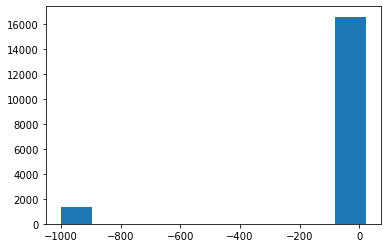

In [23]:
X_test_hierarchical_gr = X_test_hierarchical.join(df_feat[['Mean_1','Mean_2']],how='left')

X_test_hierarchical_gr = X_test_hierarchical_gr[(X_test_hierarchical_gr['Mean_1']>-900) & (X_test_hierarchical_gr['Mean_2']>-900)]
y_test_original_gr = y_test_original[X_test_hierarchical_gr.index]


X_test_hierarchical_gr = X_test_hierarchical_gr.drop(['Mean_1','Mean_2'],axis=1)
r_feat = [f for f in X_test_hierarchical_gr.columns if (f[-2:]=="_2") or (f=='g-r_max') or (f=='g-r_mean') or (f=='r-W2') or (f=='r-W3')]
g_feat = [f for f in X_test_hierarchical_gr.columns if (f[-2:]=="_1") or (f=='g-r_max') or (f=='g-r_mean') or (f=='g-W2') or (f=='g-W3')]


X_test_hierarchical_g = X_test_hierarchical_gr.copy()
print(X_test_hierarchical_g)
X_test_hierarchical_g[r_feat] = -999
print(X_test_hierarchical_g)

X_test_hierarchical_r = X_test_hierarchical_gr.copy()
X_test_hierarchical_r[g_feat] = -999

plt.hist(X_test_hierarchical_g['g-W2'].values)

In [24]:
Accuracy_first_layer = np.array(list_Accuracy_first_layer)
print("macro Acc first layer",np.mean(Accuracy_first_layer), np.std(Accuracy_first_layer))

Balanced_Accuracy_first_layer = np.array(list_Balanced_Accuracy_first_layer)
print("Balanced Acc first layer", np.mean(Balanced_Accuracy_first_layer), np.std(Balanced_Accuracy_first_layer))

precision_first_layer = np.array(list_precision_first_layer)
print("Precision", np.mean(precision_first_layer), np.std(precision_first_layer))

recall_first_layer = np.array(list_recall_first_layer)
print("Recall ",np.mean(recall_first_layer), np.std(recall_first_layer))

F1_first_layer = np.array(list_F1_Accuracy_first_layer)
print("F1 ", np.mean(F1_first_layer), np.std(F1_first_layer))


Accuracy_last_layer = np.array(list_Accuracy_last_layer)
print("Accuracy ",np.mean(Accuracy_last_layer), np.std(Accuracy_last_layer))

Balanced_Accuracy_last_layer = np.array(list_Balanced_Accuracy_last_layer)
print("Balanced Accuracy ",np.mean(Balanced_Accuracy_last_layer), np.std(Balanced_Accuracy_last_layer))

precision_last_layer = np.array(list_precision_last_layer)
print("Precision", np.mean(precision_last_layer), np.std(precision_last_layer))

recall_last_layer = np.array(list_recall_last_layer)
print("Recall ",np.mean(recall_last_layer), np.std(recall_last_layer))

F1_last_layer = np.array(list_F1_Accuracy_last_layer)
print("F1 ", np.mean(F1_last_layer), np.std(F1_last_layer))


array_cnf_matrix = np.array(list_cnf_matrix)

array_cnf_matrix_hier = np.array(list_cnf_matrix_hier) 
#print(array_cnf_matrix_hier)

#print(np.mean(array_cnf_matrix_hier,axis=0))
#print(np.std(array_cnf_matrix_hier,axis=0))

macro Acc first layer 0.9872165922363448 0.00041323466847334255
Balanced Acc first layer 0.9847939244603479 0.0008092138770944471
Precision 0.9583107124758634 0.004515899234879815
Recall  0.9847939244603479 0.0008092138770944471
F1  0.9706242753157899 0.002531632128805327
Accuracy  0.8295989350738578 0.0036053231126052503
Balanced Accuracy  0.7594999236030494 0.012850067925275837
Precision 0.5542064652636881 0.0071437922167063485
Recall  0.7594999236030494 0.012850067925275837
F1  0.5853081960245535 0.007197389205812454


Normalized confusion matrix


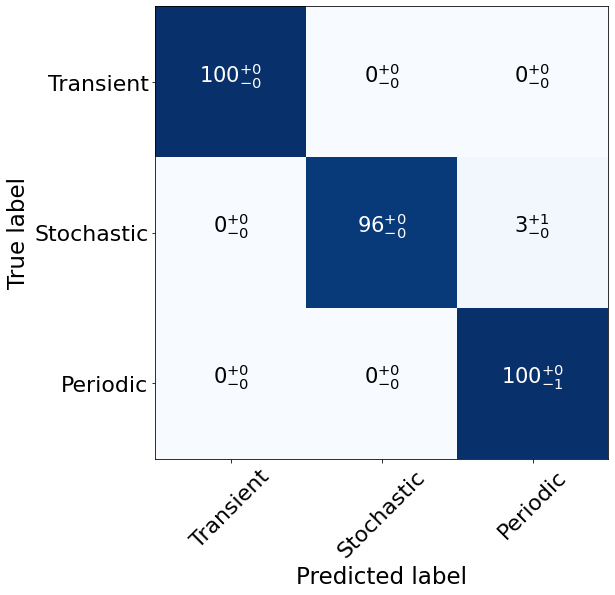

In [25]:
#hierarchical conf matrix

plot_confusion_matrix(np.median(array_cnf_matrix_hier,axis=0), np.percentile(array_cnf_matrix_hier,5,axis=0),np.percentile(array_cnf_matrix_hier,95,axis=0),cm_classes_hierachical,'final_BHRF_model/test_conf_matrix_hierarchical_original_hierarchical_classes.pdf',font=21,fig_x = 10, fig_y = 8)
plt.savefig('plots/conf_matrix_hierarchical.pdf')


Normalized confusion matrix


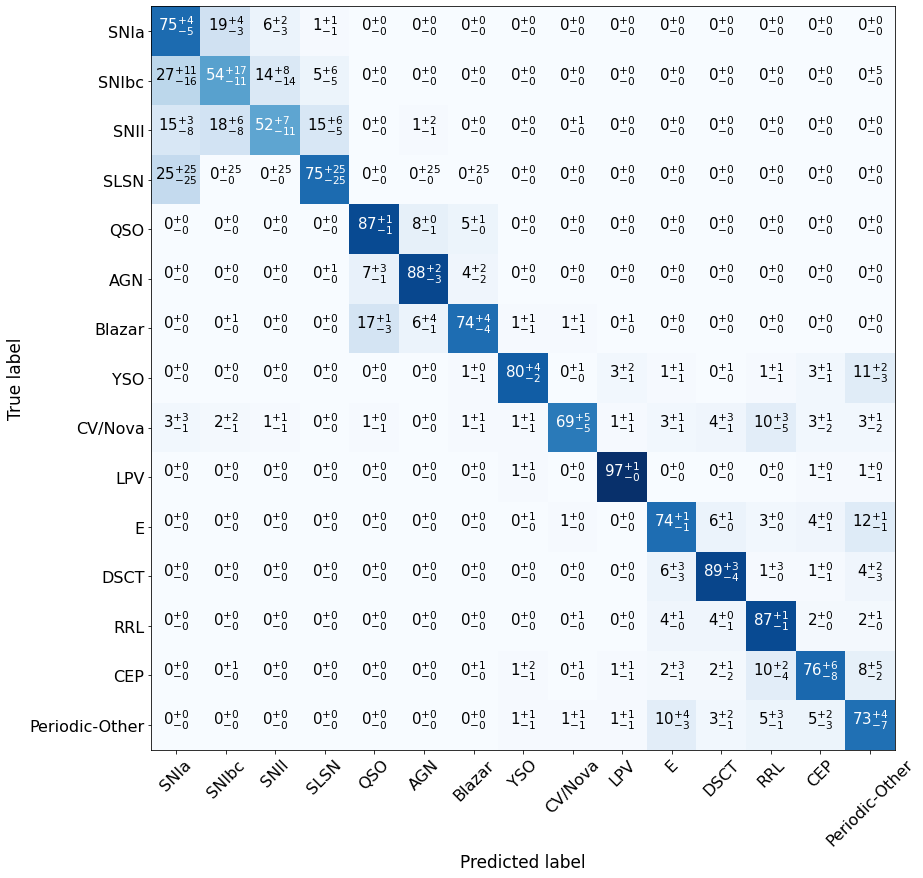

In [26]:
#multiclass conf matrix
#print(np.percentile(array_cnf_matrix,95,axis=0))
#print(np.percentile(array_cnf_matrix,50,axis=0))

plot_confusion_matrix(np.median(array_cnf_matrix,axis=0), np.percentile(array_cnf_matrix,5,axis=0),np.percentile(array_cnf_matrix,95,axis=0),label_order, 'final_BHRF_model/test_conf_matrix_multiclass_original_hierarchical_classes.pdf',font=15,fig_x = 20, fig_y = 12)
plt.savefig('plots/conf_matrix_multiclass.pdf')


In [27]:
#function to create plots for each class

def plot_accuracy_1class(bins, gr_array, g_array, r_array, gr_nsamp, g_nsamp, r_nsamp,label,ax = None, xlabel = True, ylabel = True, xlabel_name ='average magnitude',xlimit=(13, 21),lowper=5,highper=95,nsam_perbin=10):
    ax = ax or plt.gca()
    
    
    mask = (gr_nsamp<nsam_perbin)
    gr_array[mask] = np.nan
    
    gr_median = np.nanmedian(gr_array,axis=0)
    gr_low = np.nanpercentile(gr_array,lowper,axis=0)
    gr_high = np.nanpercentile(gr_array,highper,axis=0)
    
    gr_n = np.where(gr_median>-1)
    
    gr_median = gr_median[gr_n[0]]
    gr_low = gr_low[gr_n[0]]
    gr_high = gr_high[gr_n[0]]
    gr_bins = bins[gr_n[0]]
    
    ax.plot(gr_bins,gr_median,'k>-',label=r'g+r')
    ax.fill_between(gr_bins, gr_low, gr_high,alpha=0.2,  facecolor='black')

    mask = (g_nsamp<nsam_perbin)
    g_array[mask] = np.nan
    
    g_median = np.nanmedian(g_array,axis=0)
    g_low = np.nanpercentile(g_array,lowper,axis=0)
    g_high = np.nanpercentile(g_array,highper,axis=0)
    
    g_n = np.where(g_median>-1)
    g_median = g_median[g_n[0]]
    g_low = g_low[g_n[0]]
    g_high = g_high[g_n[0]]
    g_bins = bins[g_n[0]]
    
    
    ax.plot(g_bins,g_median,color='#56E03A',marker='o',linestyle='-',label=r'g')
    ax.fill_between(g_bins, g_low, g_high,alpha=0.2,  facecolor='#56E03A')
    
    mask = (r_nsamp<nsam_perbin)
    r_array[mask] = np.nan
    
    r_median = np.nanmedian(r_array,axis=0)
    r_low = np.nanpercentile(r_array,lowper,axis=0)
    r_high = np.nanpercentile(r_array,highper,axis=0)
    
    r_n = np.where(r_median>-1)
    
    r_median = r_median[r_n[0]]
    r_low = r_low[r_n[0]]
    r_high = r_high[r_n[0]]
    r_bins = bins[r_n[0]]
    
    ax.plot(r_bins,r_median,color='#D42F4B',marker='s',linestyle='-',label=r'r')
    ax.fill_between(r_bins, r_low, r_high,alpha=0.2,  facecolor='#D42F4B')
    
    ax.set_title(label)
    ax.set_ylim(0,1.1)
    ax.set_xlim(xlimit)
    plt.legend(loc= 'lower right',fontsize=14)
    if xlabel: ax.set_xlabel(xlabel_name,fontsize=12)
    if ylabel: ax.set_ylabel('Recall',fontsize=12)
    
    

/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: 

(20, 18)
(18,)


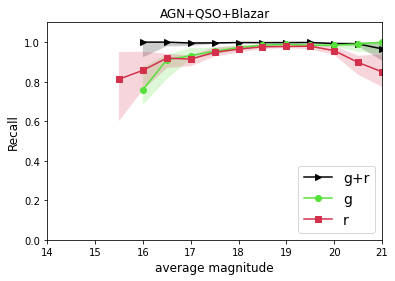

In [28]:
plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_AQB, array_acc_mag_gband_AQB, array_acc_mag_rband_AQB, array_nsamp_mag_grband_AQB, array_nsamp_mag_gband_AQB, array_nsamp_mag_rband_AQB,'AGN+QSO+Blazar',xlimit=(14,21))
plt.savefig('plots/recall_agn_qso_blazar_for_mag.pdf',bbox_inches='tight')
print((array_acc_mag_grband_AQB).shape)
print(bins_mag_r.shape)

/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: 

/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: 

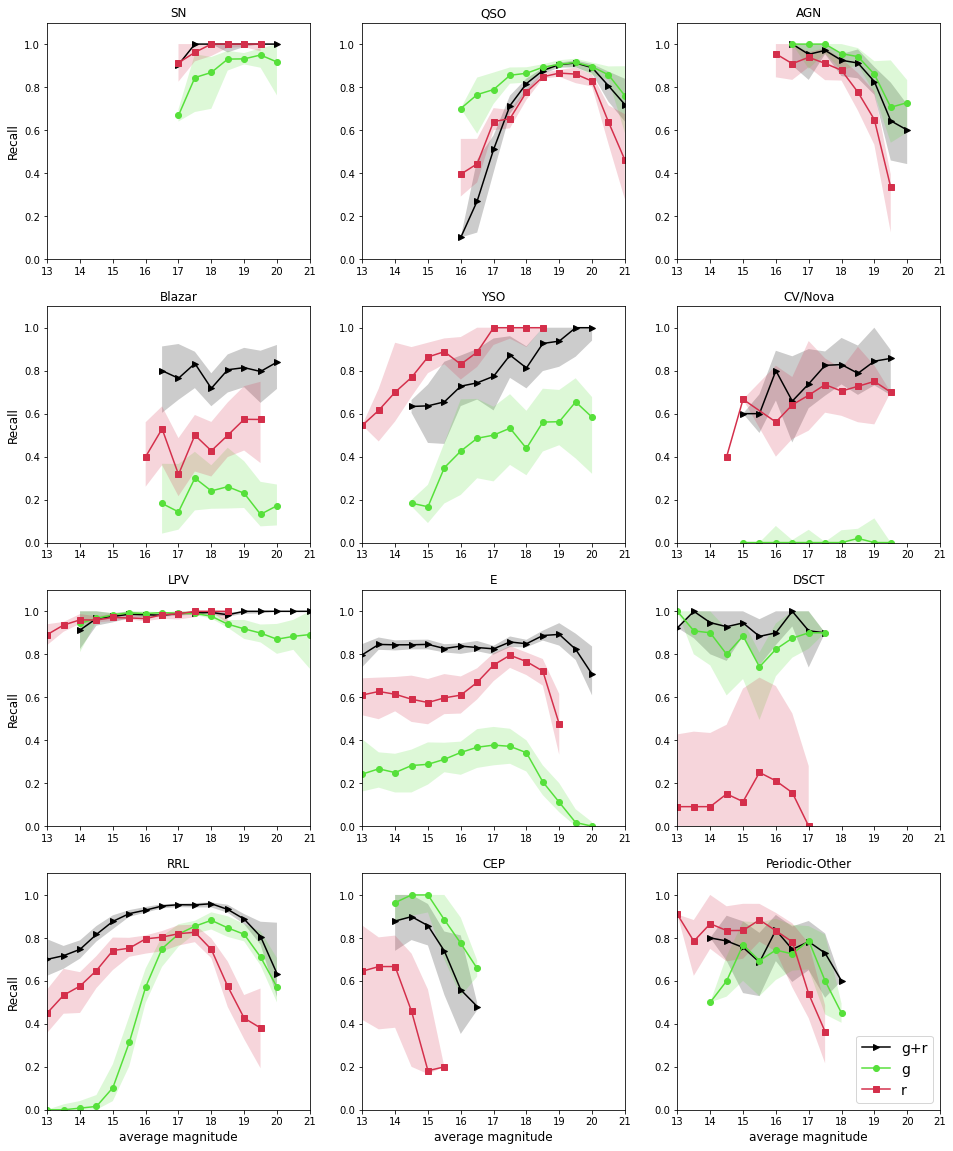

In [29]:
fig, axarr = plt.subplots(4, 3, figsize=(16,20))

plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_transients, array_acc_mag_gband_transients, array_acc_mag_rband_transients, array_nsamp_mag_grband_transients, array_nsamp_mag_gband_transients, array_nsamp_mag_rband_transients,'SN',ax=axarr[0,0],xlabel=False )



plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_QSO, array_acc_mag_gband_QSO, array_acc_mag_rband_QSO, array_nsamp_mag_grband_QSO, array_nsamp_mag_gband_QSO, array_nsamp_mag_rband_QSO,'QSO', ax=axarr[0,1],xlabel=False, ylabel=False )
plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_AGN, array_acc_mag_gband_AGN, array_acc_mag_rband_AGN, array_nsamp_mag_grband_AGN, array_nsamp_mag_gband_AGN, array_nsamp_mag_rband_AGN,'AGN', ax=axarr[0,2],xlabel=False, ylabel=False )
plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_Blazar, array_acc_mag_gband_Blazar, array_acc_mag_rband_Blazar, array_nsamp_mag_grband_Blazar, array_nsamp_mag_gband_Blazar, array_nsamp_mag_rband_Blazar,'Blazar', ax=axarr[1,0],xlabel=False )
plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_YSO, array_acc_mag_gband_YSO, array_acc_mag_rband_YSO, array_nsamp_mag_grband_YSO, array_nsamp_mag_gband_YSO, array_nsamp_mag_rband_YSO,'YSO', ax=axarr[1,1],ylabel=False,xlabel=False )
plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_CV, array_acc_mag_gband_CV, array_acc_mag_rband_CV, array_nsamp_mag_grband_CV, array_nsamp_mag_gband_CV, array_nsamp_mag_rband_CV,'CV/Nova',  ax=axarr[1,2],ylabel=False,xlabel=False)
plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_LPV, array_acc_mag_gband_LPV, array_acc_mag_rband_LPV, array_nsamp_mag_grband_LPV, array_nsamp_mag_gband_LPV, array_nsamp_mag_rband_LPV,'LPV',  ax=axarr[2,0],xlabel=False)





plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_EB, array_acc_mag_gband_EB, array_acc_mag_rband_EB, array_nsamp_mag_grband_EB, array_nsamp_mag_gband_EB, array_nsamp_mag_rband_EB,'E', ax=axarr[2,1],xlabel=False, ylabel=False )
plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_DSCT, array_acc_mag_gband_DSCT, array_acc_mag_rband_DSCT, array_nsamp_mag_grband_DSCT, array_nsamp_mag_gband_DSCT, array_nsamp_mag_rband_DSCT,'DSCT', ax=axarr[2,2],xlabel=False, ylabel=False )
plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_RRL, array_acc_mag_gband_RRL, array_acc_mag_rband_RRL, array_nsamp_mag_grband_RRL, array_nsamp_mag_gband_RRL, array_nsamp_mag_rband_RRL,'RRL', ax=axarr[3,0] )
plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_Ceph, array_acc_mag_gband_Ceph, array_acc_mag_rband_Ceph, array_nsamp_mag_grband_Ceph, array_nsamp_mag_gband_Ceph, array_nsamp_mag_rband_Ceph,'CEP', ax=axarr[3,1],ylabel=False )
plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_Other, array_acc_mag_gband_Other, array_acc_mag_rband_Other, array_nsamp_mag_grband_Other, array_nsamp_mag_gband_Other, array_nsamp_mag_rband_Other,'Periodic-Other', ax=axarr[3,2],ylabel=False)

plt.savefig('plots/recall_all_for_mag.pdf',bbox_inches='tight')



In [30]:
def plot_accuracy_1class_nsamps(bins_gr, bins_g, bins_r, gr_array, g_array, r_array, gr_nsamp, g_nsamp, r_nsamp,label,ax = None, xlabel = True, ylabel = True, xlabel_name =r'$\# \mathrm{detections}$',xlimit=(5,150),lowper=5,highper=95,nsam_perbin=10):
    
    ax = ax or plt.gca()
    #print(bins)
    #print(gr_array)
    
    mask = (gr_nsamp<nsam_perbin)
    gr_array[mask] = np.nan
    
    gr_median = np.nanmedian(gr_array,axis=0)
    gr_low = np.nanpercentile(gr_array,lowper,axis=0)
    gr_high = np.nanpercentile(gr_array,highper,axis=0)
    
    gr_n = np.where(gr_median>-1)
    
    gr_median = gr_median[gr_n[0]]
    gr_low = gr_low[gr_n[0]]
    gr_high = gr_high[gr_n[0]]
    gr_bins = bins_gr[gr_n[0]]
    
    ax.plot(gr_bins,gr_median,'k>-',label=r'g+r')
    ax.fill_between(gr_bins, gr_low, gr_high,alpha=0.2,  facecolor='black')

    mask = (g_nsamp<nsam_perbin)
    g_array[mask] = np.nan
    
    g_median = np.nanmedian(g_array,axis=0)
    g_low = np.nanpercentile(g_array,lowper,axis=0)
    g_high = np.nanpercentile(g_array,highper,axis=0)
    
    g_n = np.where(g_median>-1)
    g_median = g_median[g_n[0]]
    g_low = g_low[g_n[0]]
    g_high = g_high[g_n[0]]
    g_bins = bins_g[g_n[0]]
    
    
    ax.plot(g_bins,g_median,color='#56E03A',marker='o',linestyle='-',label=r'g')
    ax.fill_between(g_bins, g_low, g_high,alpha=0.2,  facecolor='#56E03A')
    
    mask = (r_nsamp<nsam_perbin)
    r_array[mask] = np.nan
    
    r_median = np.nanmedian(r_array,axis=0)
    r_low = np.nanpercentile(r_array,lowper,axis=0)
    r_high = np.nanpercentile(r_array,highper,axis=0)
    
    r_n = np.where(r_median>-1)
    
    r_median = r_median[r_n[0]]
    r_low = r_low[r_n[0]]
    r_high = r_high[r_n[0]]
    r_bins = bins_r[r_n[0]]
    
    ax.plot(r_bins,r_median,color='#D42F4B',marker='s',linestyle='-',label=r'r')
    ax.fill_between(r_bins, r_low, r_high,alpha=0.2,  facecolor='#D42F4B')
    
    ax.set_title(label)
    ax.set_ylim(0,1.1)
    ax.set_xlim(xlimit)
    ax.set_xscale('log')
    plt.legend(loc='lower right', fontsize=14)
    if xlabel: ax.set_xlabel(xlabel_name,fontsize=12)
    if ylabel: ax.set_ylabel('Recall',fontsize=12)
    
    

/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: 

No handles with labels found to put in legend.
/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/opt/anaconda3/lib/pyt

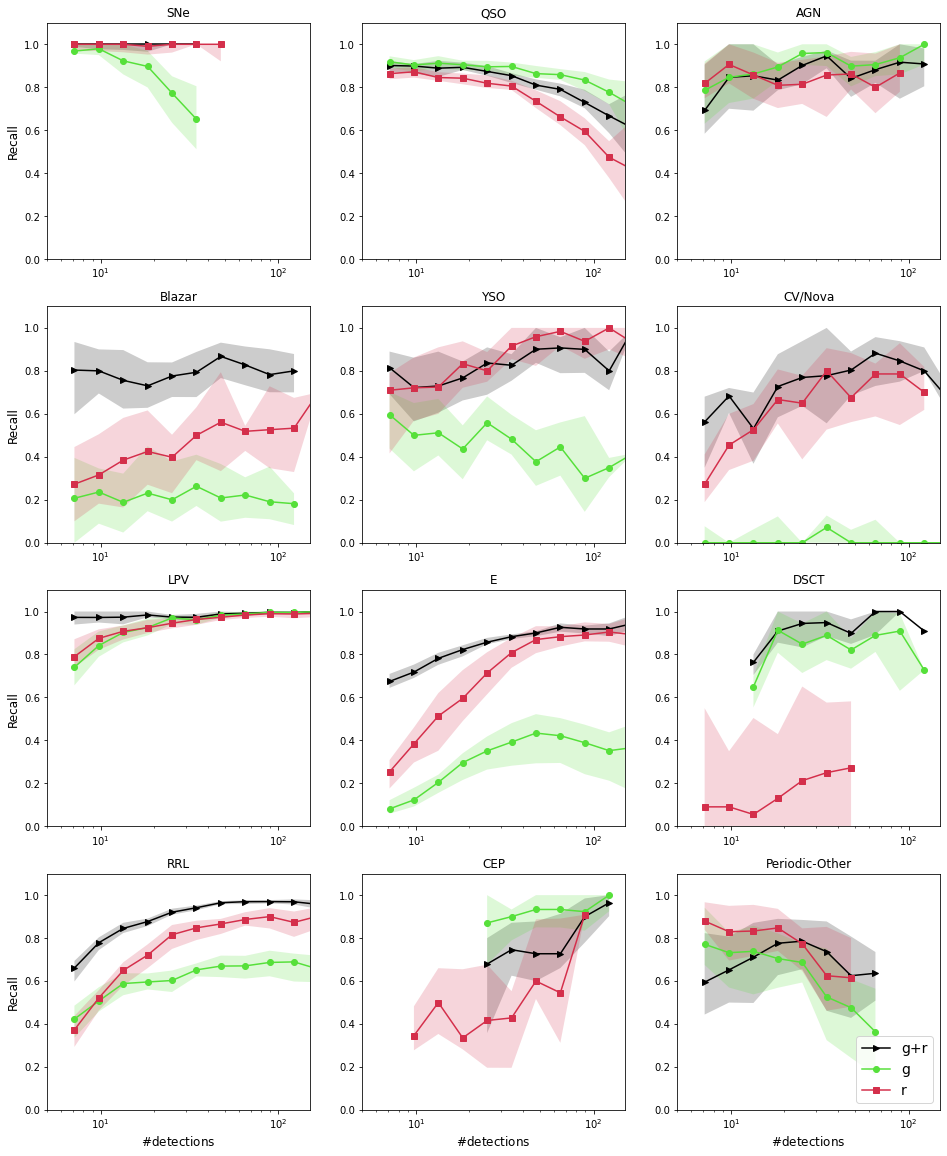

In [31]:
fig2, axarr2 = plt.subplots(4, 3, figsize=(16,20))
plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_transients, array_acc_nsamp_gband_transients, array_acc_nsamp_rband_transients, array_nsamp_nsamp_grband_transients, array_nsamp_nsamp_gband_transients, array_nsamp_nsamp_rband_transients,'SNe',ax=axarr2[0,0],xlabel=False )


plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_QSO, array_acc_nsamp_gband_QSO, array_acc_nsamp_rband_QSO, array_nsamp_nsamp_grband_QSO, array_nsamp_nsamp_gband_QSO, array_nsamp_nsamp_rband_QSO,'QSO', ax=axarr2[0,1],xlabel=False, ylabel=False )
plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_AGN, array_acc_nsamp_gband_AGN, array_acc_nsamp_rband_AGN, array_nsamp_nsamp_grband_AGN, array_nsamp_nsamp_gband_AGN, array_nsamp_nsamp_rband_AGN,'AGN', ax=axarr2[0,2],xlabel=False, ylabel=False )
plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_Blazar, array_acc_nsamp_gband_Blazar, array_acc_nsamp_rband_Blazar, array_nsamp_nsamp_grband_Blazar, array_nsamp_nsamp_gband_Blazar, array_nsamp_nsamp_rband_Blazar,'Blazar', ax=axarr2[1,0],xlabel=False )
plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_YSO, array_acc_nsamp_gband_YSO, array_acc_nsamp_rband_YSO, array_nsamp_nsamp_grband_YSO, array_nsamp_nsamp_gband_YSO, array_nsamp_nsamp_rband_YSO,'YSO', ax=axarr2[1,1],ylabel=False,xlabel=False )
plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_CV, array_acc_nsamp_gband_CV, array_acc_nsamp_rband_CV, array_nsamp_nsamp_grband_CV, array_nsamp_nsamp_gband_CV, array_nsamp_nsamp_rband_CV,'CV/Nova', ax=axarr2[1,2],ylabel=False,xlabel=False)
plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_LPV, array_acc_nsamp_gband_LPV, array_acc_nsamp_rband_LPV, array_nsamp_nsamp_grband_LPV, array_nsamp_nsamp_gband_LPV, array_nsamp_nsamp_rband_LPV,'LPV', ax=axarr2[2,0],xlabel=False )



plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_EB, array_acc_nsamp_gband_EB, array_acc_nsamp_rband_EB, array_nsamp_nsamp_grband_EB, array_nsamp_nsamp_gband_EB, array_nsamp_nsamp_rband_EB,'E', ax=axarr2[2,1],xlabel=False, ylabel=False )
plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_DSCT, array_acc_nsamp_gband_DSCT, array_acc_nsamp_rband_DSCT, array_nsamp_nsamp_grband_DSCT, array_nsamp_nsamp_gband_DSCT, array_nsamp_nsamp_rband_DSCT,'DSCT', ax=axarr2[2,2],xlabel=False, ylabel=False )
plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_RRL, array_acc_nsamp_gband_RRL, array_acc_nsamp_rband_RRL, array_nsamp_nsamp_grband_RRL, array_nsamp_nsamp_gband_RRL, array_nsamp_nsamp_rband_RRL,'RRL', ax=axarr2[3,0] )
plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_Ceph, array_acc_nsamp_gband_Ceph, array_acc_nsamp_rband_Ceph, array_nsamp_nsamp_grband_Ceph, array_nsamp_nsamp_gband_Ceph, array_nsamp_nsamp_rband_Ceph,'CEP', ax=axarr2[3,1],ylabel=False )
plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_Other, array_acc_nsamp_gband_Other, array_acc_nsamp_rband_Other, array_nsamp_nsamp_grband_Other, array_nsamp_nsamp_gband_Other, array_nsamp_nsamp_rband_Other,'Periodic-Other', ax=axarr2[3,2],ylabel=False)



plt.savefig('plots/recall_all_for_ndet.pdf',bbox_inches='tight')

/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: 

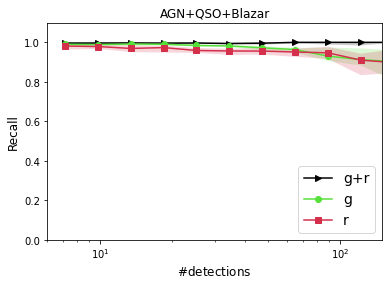

In [32]:
plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_AQB, array_acc_nsamp_gband_AQB, array_acc_nsamp_rband_AQB, array_nsamp_nsamp_grband_AQB, array_nsamp_nsamp_gband_AQB, array_nsamp_nsamp_rband_AQB,'AGN+QSO+Blazar',xlimit=(6,150))

plt.savefig('plots/recall_agn_qso_blazar_for_ndet.pdf',bbox_inches='tight')